In [1]:
%matplotlib inline
import platform
print(platform.python_version())
from ROOT import TFile,vector
import ROOT

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import math


import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

import seaborn as sns

3.5.2
Welcome to JupyROOT 6.14/08


In [26]:
# davios functions for plotting...
  
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

def Tune1(df):
    return df['xsec_tune1_weight'].values

def CV(df):
    wgt = df['xsec_corr_weight'].values
    if False:
#     if 'new_weight' in df.columns:
        tmpweights1 = df['new_weight'].values

    else:
        tmpweights1 = []
        for i in range(len(wgt)):
            tmpweights1.append(1.0)
    
    if 'pot_weight' in df.columns:
        tmpweights2 = df['pot_weight'].values
    else:
        tmpweights2 = []
        for i in range(len(wgt)):
            tmpweights2.append(1.0)
            
    for i in range(len(wgt)):
        wgt[i] = wgt[i]*tmpweights1[i]*tmpweights2[i]
        
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    
    return wgt

def Spline(df):
    wgt = df['spline_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt


class sampHist:

    def __init__(self,samp_df,samp_l,samp_c,samp_wind,samp_s):
        self._df = samp_df.copy()
        self._label = samp_l
        self._color = samp_c
        self._scale = samp_s
        self._wi = samp_wind
        if samp_wind == 0:
            self._wgt = np.ones(len(samp_df))
        if samp_wind == 1:
            self._wgt = CV(samp_df)

    def setweight(self,windex):
        if windex == 0:
            self._wgt = np.ones(len(self._df))
        if windex == 1:
            self._wgt = CV(self._df)

    def dist(self,s_var):
        return self._df[s_var].values

    def cosdist(self,s_var):
        return np.cos(self._df[s_var].values)

    def applycut(self,s_cut):
        newhist = copy.deepcopy(self)
        newhist._df = self._df.query(s_cut)
        newhist.setweight(self._wi)
        return newhist

class SimpleHisto:

    def __init__ (self,df_df,f_scale,i_wgt,s_color,s_label):
        temp_df = df_df.copy()
        temp_df['myscale'] = f_scale
        self.mydf = temp_df
        self.mycolor = s_color
        self.mylabel = s_label
        self.iwgt = i_wgt

        self.mycut = 'Enu_1m1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def ClearCut(self):
        self.mycut = 'Enu_1m1p > 0'

    def GetHist(self,s_varname):
        temp_df = self.mydf.query(self.mycut)
        if self.iwgt == 1:
            myweight = CV(temp_df)
        elif self.iwgt == 0:
            myweight = np.ones(len(temp_df))
        return temp_df[s_varname].values,myweight,temp_df['myscale'].values,self.mycolor,self.mylabel

def GetErrorsData(xobs,CL=0.6827):
    step    = 0.01
    upperBoundary = int(max(10,xobs+5*np.sqrt(xobs)))
    r = np.arange(0.01,upperBoundary,step)
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    return xobs_low,xobs_high

class StackedHisto:

    def  __init__ (self,a_df_mc,a_df_scale):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layeriwgt = []
        self.stratxweight = []

        temp_a_df = []
        for i in range(len(a_df_mc)):
            temp_df = a_df_mc[i].copy()
            temp_df['myscale'] = a_df_scale[i]
            temp_a_df.append(temp_df)
        self.mymc = pd.concat(temp_a_df)
        self.mycut ='_pi0mass >0'


    def ClearCut(self):
        self.mycut = 'Enu_1m1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def AddLayer(self,df_layer,df_scale,i_wgt,s_label,s_color):
        temp_df = df_layer.copy()
        temp_df['myscale'] = df_scale
        self.mylayer.append(temp_df)
        self.layerlabel.append(s_label)
        self.layercolor.append(s_color)
        self.layeriwgt.append(i_wgt)

    def AddStrata(self,s_strata,s_label,s_color,f_wgt=1.0):
        self.mystrata.append(s_strata)
        self.stratalabel.append(s_label)
        self.stratacolor.append(s_color)
        self.stratxweight.append(f_wgt)

    def GetHists(self,s_varname):
        a_vals = []        # (nxN)
        a_wgts = []
        a_scale = []
        a_cols = []        # (nx1)
        a_labels = []

        # first, run  through strata
        for i in range(len(self.mystrata)):
            # isolate this stratum with current cut
            temp_df = self.mymc.query(self.mystrata[i]+' and '+self.mycut)

            a_vals.append(temp_df[s_varname].values)
            a_wgts.append(CV(temp_df) * self.stratxweight[i])   # ah, this is if we want to scale an individual stratum
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.stratacolor[i])
            a_labels.append(self.stratalabel[i])

        for i in range(len(self.mylayer)):
            temp_df = self.mylayer[i].query(self.mycut)

            a_vals.append(temp_df[s_varname].values)
            if self.layeriwgt[i] == 1:
                a_wgts.append(CV(temp_df))
            elif self.layeriwgt[i] == 0:
                a_wgts.append(np.ones(len(temp_df)))
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.layercolor[i])
            a_labels.append(self.layerlabel[i])

        return  np.asarray(a_vals),np.asarray(a_wgts),np.asarray(a_scale),a_cols,a_labels

    def ClearLayers(self):
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layerwgt = []

    def ClearStrata(self):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []


class distVar:

    def __init__(self,s_name,n_range,s_label='',s_cov=''):
        self.myname = s_name
        self.myrange = n_range
        self.myscov = s_cov
        if s_label == '':
            self.mylabel = s_name
        else:
            self.mylabel = s_label
            
def PmuGivenX(mu,x):

    # Returns the probability density value that the true mean is mu given that you
    # have observed x events. Actually employs a series approximation because the real formula
    # involves a very very large numerator and denominator and overflows even high precision
    # variables if your bins contain more than a few hundred events
    # Approximation is good to O(0.1%) or better at all values

    pi  = np.pi
    c   = [1.,-1./12,1./288,139./51840,-571./2488320,-163879./209018880]

    if x == 0:
        return np.exp(-mu)
    else:
        poly = sum(c[i]/x**(i+0.5) for i in range(len(c)))
        return 1/np.sqrt(2*pi)*np.exp(x+x*np.log(mu/x)-mu)*poly


def distplot_wratio_davio(myvar,nbins,myrange,stackedhists,datahist,stxcoord,m_cov,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #consFac is new and consolidates all MC strata whose contribution is less than a given percent threshold.
    # (my legend was too full of useless stuff)

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    data_vals,data_wgt,data_scale,_,data_label = datahist.GetHist(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])


    vals_data_raw,_ = np.histogram(data_vals,nbins,range=myrange,weights=data_wgt)
    vals_data,_ = np.histogram(data_vals,nbins,range=myrange,weights=np.multiply(data_wgt,data_scale))
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    #jarretbars
    a_obslo = []
    a_obshi = []
    for i in range(nbins):
        obslo,obshi = GetErrorsData(vals_data[i])
        a_obshi.append(obshi-vals_data[i])
        a_obslo.append(vals_data[i]-obslo)

    #m_cov is fractional, so we multiply it by MC
    for i in range(nbins):
        for j in range(nbins):
            if(vals_mc[i] > 0 and vals_mc[j] > 0):
                m_cov[i][j] *= vals_mc[i]*vals_mc[j]
#             else if math.isnan(vals_mc[i]) or math.isnan(vals_mc[j]):
#                 m_cov[i][j] = 0
            else:
                m_cov[i][j] = 0
#             else:
#                 print("uh oh!",vals_mc[i],vals_mc[j] )

    # Normalization uncertainty:
    for i in range(len(m_cov)):
        for j in range(len(m_cov[i])):
            if math.isnan(m_cov[i][j]):
                m_cov[i][j]=0.0000000001
                
    fNorm_squared = m_cov.sum() / np.power(vals_mc.sum(),2)
#     print("first", m_cov)
    print('Normalization Uncertainty:',np.sqrt(fNorm_squared))

    yerr_mc_sys = np.sqrt(np.diag(m_cov))
    yerr_mc_total = np.sqrt(np.diag(m_cov) + yerrsq_mc)

    yerrsq_data = np.zeros(nbins)
    for i in range(nbins):
        if vals_mc_raw[i] > 0:
            ndof += 1
            if vals_data[i] > 0:
                yerrsq_data[i] += (3.0*vals_data[i]*vals_mc[i]*normshift)/(vals_mc[i]*normshift+2.0*vals_data[i])
            else:
                yerrsq_data[i] += vals_mc[i]*normshift/2.0
            m_cov[i][i] += yerrsq_data[i] + yerrsq_mc[i]
        else:
            m_cov[i][i] += 999

    yerr_data = np.sqrt(yerrsq_data)

    er_rat_line = np.zeros(nbins)
    er_rat_line_sys = np.zeros(nbins)
    er_rat_dotshi = np.zeros(nbins)
    er_rat_dotslo = np.zeros(nbins)

    for i in range(nbins):
        if vals_mc[i] > 0:
            er_rat_line[i] = yerr_mc_total[i]/float(vals_mc[i])
            er_rat_line_sys[i] = yerr_mc_sys[i]/float(vals_mc[i])
            er_rat_dotshi[i] = a_obshi[i]/float(vals_mc[i])
            er_rat_dotslo[i] = a_obslo[i]/float(vals_mc[i])

    chisq = 0.0
    invcov = np.linalg.inv(m_cov)

    # calc chi2
    for i in range(nbins):
        for j in range(nbins):
            if vals_mc_raw[i] > 0 and vals_mc_raw[j] > 0 and vals_data[i]>0 and vals_data[j] >0 :
                chisq += (vals_mc[i] - vals_data[i]) * (vals_mc[j] - vals_data[j]) * invcov[i][j]
    pval = 1 - stats.chi2.cdf(chisq, ndof)
    print(chisq/float(ndof),pval)

    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ymax = max((vals_data+np.asarray(a_obshi)).max(),(vals_mc+yerr_mc_sys).max())*1.4

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Event Count',fontsize=25)
    ax1.set_ylabel('Data/MC',fontsize=25)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax0.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax0.errorbar(bincenters,vals_data,fmt='o',yerr=(a_obslo,a_obshi),color='black',capsize=5,label=data_label+' (%i)'%vals_data.sum(),markersize=8,zorder=20,elinewidth=2)
    ax0.errorbar(bincenters,vals_data,fmt='o',color='white',zorder=19,markersize=16)

    errboxes_tot = []
    errboxes_sys = []

    for i in range(len(bincenters)):
        rect0 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_sys[i])),binedges[i+1]-binedges[i],yerr_mc_sys[i]*2)
        errboxes_sys.append(rect0)
        rect1 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_total[i])),binedges[i+1]-binedges[i],yerr_mc_total[i]*2)
        errboxes_tot.append(rect1)
    pc_sys = PatchCollection(errboxes_tot,facecolor='red', alpha=.3,hatch='X',edgecolor='white')
    pc_sys_outline = PatchCollection(errboxes_tot,facecolor='none', alpha=.9,hatch='X',edgecolor='white',zorder=11)
    pc_tot = PatchCollection(errboxes_sys,facecolor=None,alpha=.1,hatch='/',zorder=12)
    ax0.add_collection(pc_sys)
    ax0.add_collection(pc_sys_outline)
    ax0.add_collection(pc_tot)
    ax0.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='MC Systematic Error')
    ax0.hist(np.zeros(1),(1,2),facecolor='red', alpha=.3,hatch='X',edgecolor='white',label='MC Sys+Stat Error')
    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=2)

    errboxes_rat_tot = []
    errboxes_rat_sys = []
    for i in range(len(er_rat_dotshi)):
        rect0 = Rectangle((binedges[i],1-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes_rat_tot.append(rect0)
        rect1 = Rectangle((binedges[i],1-er_rat_line_sys[i]),binedges[i+1]-binedges[i],er_rat_line_sys[i]*2)
        errboxes_rat_sys.append(rect1)

    pc_rat_tot = PatchCollection(errboxes_rat_tot, facecolor='red', alpha=.3)
    pc_rat_sys = PatchCollection(errboxes_rat_sys, facecolor=None, alpha=.1,hatch='/',zorder=12)
    ax1.add_collection(pc_rat_tot)
    ax1.add_collection(pc_rat_sys)
    ax1.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0)

    ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0)
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=(er_rat_dotshi,er_rat_dotslo),fmt='o',color='maroon',capsize=0,markersize=8,elinewidth=2)

    #ax1.legend(loc='lower right',fontsize=15,frameon=False)

    ax1.axhline(1,color='black',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f $\pm$ %.2f'%(vals_data.sum()/float(vals_mc.sum()),np.sqrt(fNorm_squared)),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)

    plt.tight_layout()

    return fig,ax0,ax1,pval

def distplot_mc(myvar,nbins,myrange,stackedhists,stxcoord,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #for plotting truth variables

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])


   
  

   

    fig,ax = plt.subplots(figsize=fs)

    ymax = (vals_mc).max()*1.4

    ax.set_ylim(0,ymax)
    ax.set_xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Event Count',fontsize=25)
    ax.set_title('MCC9 MC',fontsize=30)

    ax.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=2)

    
    plt.tight_layout()

    return fig,ax

In [7]:
NUMU_R1_POT = 4.71579e+20
NUE_R1_POT  = 9.80259e+22
NUMU_R3_POT = 8.98773223801e+20
NUE_R3_POT = 4.707047e+22


FAKE_DATA_1_RUN1_POT = 1.925e20
FAKE_DATA_1_RUN3_POT = 2.83e20

FAKE_DATA_2_RUN1_POT = 3.617e+20
FAKE_DATA_2_RUN3_POT = 3.841e+20

FAKE_DATA_3_RUN1_POT = 3.840e+20
FAKE_DATA_3_RUN3_POT = 3.968e+20

FAKE_DATA_4_RUN1_POT = 3.86746111569e+20
FAKE_DATA_4_RUN3_POT = 3.92745929386e+20

FAKE_DATA_5_RUN1_POT = 7.02e+20

POT_SCALE_FACTOR = 1.0 #if I feel like playing with scaling
# CURRENT TOTAL
DATA_POT_TOTAL_1 = FAKE_DATA_1_RUN1_POT+FAKE_DATA_1_RUN3_POT
DATA_POT_TOTAL_2 = FAKE_DATA_2_RUN1_POT+FAKE_DATA_2_RUN3_POT
DATA_POT_TOTAL_3 = FAKE_DATA_3_RUN1_POT+FAKE_DATA_3_RUN3_POT
DATA_POT_TOTAL_4 = FAKE_DATA_4_RUN1_POT+FAKE_DATA_4_RUN3_POT
DATA_POT_TOTAL_5 = FAKE_DATA_5_RUN1_POT
print("total POT: ",DATA_POT_TOTAL_1,DATA_POT_TOTAL_2,DATA_POT_TOTAL_3,DATA_POT_TOTAL_4,DATA_POT_TOTAL_5)

total POT:  4.755e+20 7.458e+20 7.808e+20 7.79492040955e+20 7.02e+20


In [8]:
NUMU_R1_FAKE1_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE2_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_2_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE2_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_2_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE3_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_3_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE3_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_3_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE4_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_4_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE4_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_4_RUN1_POT)/ float(NUE_R1_POT)
NUMU_R1_FAKE5_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_5_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE5_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_5_RUN1_POT)/ float(NUE_R1_POT)


NUMU_R3_FAKE1_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NUE_R3_POT)
NUMU_R3_FAKE2_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_2_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE2_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_2_RUN3_POT)/ float(NUE_R3_POT)
NUMU_R3_FAKE3_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_3_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE3_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_3_RUN3_POT)/ float(NUE_R3_POT)
NUMU_R3_FAKE4_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_4_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE4_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_4_RUN3_POT)/ float(NUE_R3_POT)

In [11]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?
tag = 'Nov_20_run1_numu'
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run1_nue'
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run1_ext'
df_ext_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)
tag ='Nov_20_open_run1'
df_data_goodruns_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Nov_20_run2_numu'
df_numu_r2_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run2_nue'
df_nue_r2_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)

tag = 'Nov_20_run3_numu'
df_numu_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run3_nue'
df_nue_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run3_ext'
df_ext_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)

# tag = 'Aug_19_fake1_run3'
# df_fakedata1_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# tag = 'Aug_19_fake1_run1'
# df_fakedata1_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

# tag = 'Aug_19_fake2_run3'
# df_fakedata2_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# tag = 'Aug_19_fake2_run1'
# df_fakedata2_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

# tag = 'Aug_19_fake3_run3'
# df_fakedata3_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# tag = 'Aug_19_fake3_run1'
# df_fakedata3_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Dec_17_fake4_run3'
df_fakedata4_goodruns_run3_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Dec_17_fake4_run1'
df_fakedata4_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Dec_17_fake5_run1'
df_fakedata5_goodruns_run1_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

In [45]:
cuts = 'InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 '

RSE = ['run','subrun','event']
sort = 'shower1_E_Y'
# now apply cuts
df_numu_pi0 = df_numu_goodruns_pmtprecut.query(cuts+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_pi0 = df_numu_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(df_numu_goodruns_pmtprecut['xsec_corr_weight'].values)
df_nue_pi0 = df_nue_goodruns_pmtprecut.query(cuts + ' and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_pi0 = df_nue_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

df_numu_r3_pi0 = df_numu_r3_goodruns_pmtprecut.query(cuts+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_r3_pi0 = df_numu_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_nue_r3_pi0 = df_nue_r3_goodruns_pmtprecut.query(cuts+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_r3_pi0 = df_nue_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

df_fakedata4_run1_pi0 = df_fakedata4_goodruns_run1_pmtprecut.query(cuts)
df_fakedata4_run1_pi0 = df_fakedata4_run1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata4_run3_pi0 = df_fakedata4_goodruns_run3_pmtprecut.query(cuts)
df_fakedata4_run3_pi0 = df_fakedata4_run3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_fakedata5_run1_pi0 = df_fakedata5_goodruns_run1_pmtprecut.query(cuts)
df_fakedata5_run1_pi0 = df_fakedata5_run1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_fakedata4_run1_pi0))
print(len(df_fakedata4_goodruns_run3_pmtprecut))
print(len(df_fakedata4_run3_pi0))

# weights_numu_r1_fake1_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE1_SCALE
# weights_nue_r1_fake1_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE1_SCALE
# weights_numu_r3_fake1_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE1_SCALE
# weights_nue_r3_fake1_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE1_SCALE

# weights_numu_r1_fake2_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE2_SCALE
# weights_nue_r1_fake2_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE2_SCALE
# weights_numu_r3_fake2_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE2_SCALE
# weights_nue_r3_fake2_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE2_SCALE

# weights_numu_r1_fake3_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE3_SCALE
# weights_nue_r1_fake3_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE3_SCALE
# weights_numu_r3_fake3_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE3_SCALE
# weights_nue_r3_fake3_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE3_SCALE

weights_numu_r1_fake4_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE4_SCALE
weights_nue_r1_fake4_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE4_SCALE
weights_numu_r3_fake4_pi0 = CV(df_numu_r3_pi0)*NUMU_R3_FAKE4_SCALE
weights_nue_r3_fake4_pi0 = CV(df_nue_r3_pi0)*NUE_R3_FAKE4_SCALE

weights_numu_r1_fake5_pi0 = CV(df_numu_pi0)*NUMU_R1_FAKE5_SCALE
weights_nue_r1_fake5_pi0 = CV(df_nue_pi0)*NUE_R1_FAKE5_SCALE

# weights_fakedata1_run1_pi0 = np.ones(len(df_fakedata1_run1_pi0))*FAKE_DATA_1_RUN1_POT
# weights_fakedata1_run3_pi0 = np.ones(len(df_fakedata1_run3_pi0))*FAKE_DATA_1_RUN3_POT
# weights_fakedata2_run1_pi0 = np.ones(len(df_fakedata2_run1_pi0))*FAKE_DATA_2_RUN1_POT
# weights_fakedata2_run3_pi0 = np.ones(len(df_fakedata2_run3_pi0))*FAKE_DATA_2_RUN3_POT
# weights_fakedata3_run1_pi0 = np.ones(len(df_fakedata3_run1_pi0))*FAKE_DATA_3_RUN1_POT
# weights_fakedata3_run3_pi0 = np.ones(len(df_fakedata3_run3_pi0))*FAKE_DATA_3_RUN3_POT
weights_fakedata4_run1_pi0 = np.ones(len(df_fakedata4_run1_pi0))*FAKE_DATA_4_RUN1_POT
weights_fakedata4_run3_pi0 = np.ones(len(df_fakedata4_run3_pi0))*FAKE_DATA_4_RUN3_POT
weights_fakedata5_run1_pi0 = np.ones(len(df_fakedata5_run1_pi0))*FAKE_DATA_5_RUN1_POT


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_numu_pi0.columns.tolist()
print(cols)

[1.         1.         1.         ... 1.17870595 1.14509094 1.53516845]
1447
4204
1353
['mc_label', 'xsec_tune1_weight', 'run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p'

In [34]:
#seperate out truth types
df_bnb_ncpi0 = df_numu_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
df_bnb_ccpi0 = df_numu_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
df_bnb_pi0_offvtx = df_numu_pi0.query("haspi0==1 and MC_scedr>=5 ") 
df_bnb_other_offvtx = df_numu_pi0.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good = df_numu_pi0.query("haspi0==0 and MC_scedr<5")

df_bnb_ncpi0_r3 = df_numu_r3_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
df_bnb_ccpi0_r3 = df_numu_r3_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
df_bnb_pi0_offvtx_r3 = df_numu_r3_pi0.query("haspi0==1 and MC_scedr>=5 ") 
df_bnb_other_offvtx_r3 = df_numu_r3_pi0.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good_r3 = df_numu_r3_pi0.query("haspi0==0 and MC_scedr<5")

DATA/MC:  1.0
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.82010885 0.82010885 0.82010885 ... 0.00394535 0.00394535 0.00394535]
Normalization Uncertainty: 0.20777227405153373
2.5918066412860576 0.00016916284702983564


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:424: RuntimeWarning: invalid value encountered in true_divide


hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.43698001 0.43698001 0.43698001 ... 0.00834379 0.00834379 0.00834379]
Normalization Uncertainty: 30.68659629948648
0.005955904121714789 1.0
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [1.48861591 1.48861591 1.48861591 ... 0.00716137 0.00716137 0.00716137]
Normalization Uncertainty: 4995.522285729561
0.05594408057872213 0.9999999986530835


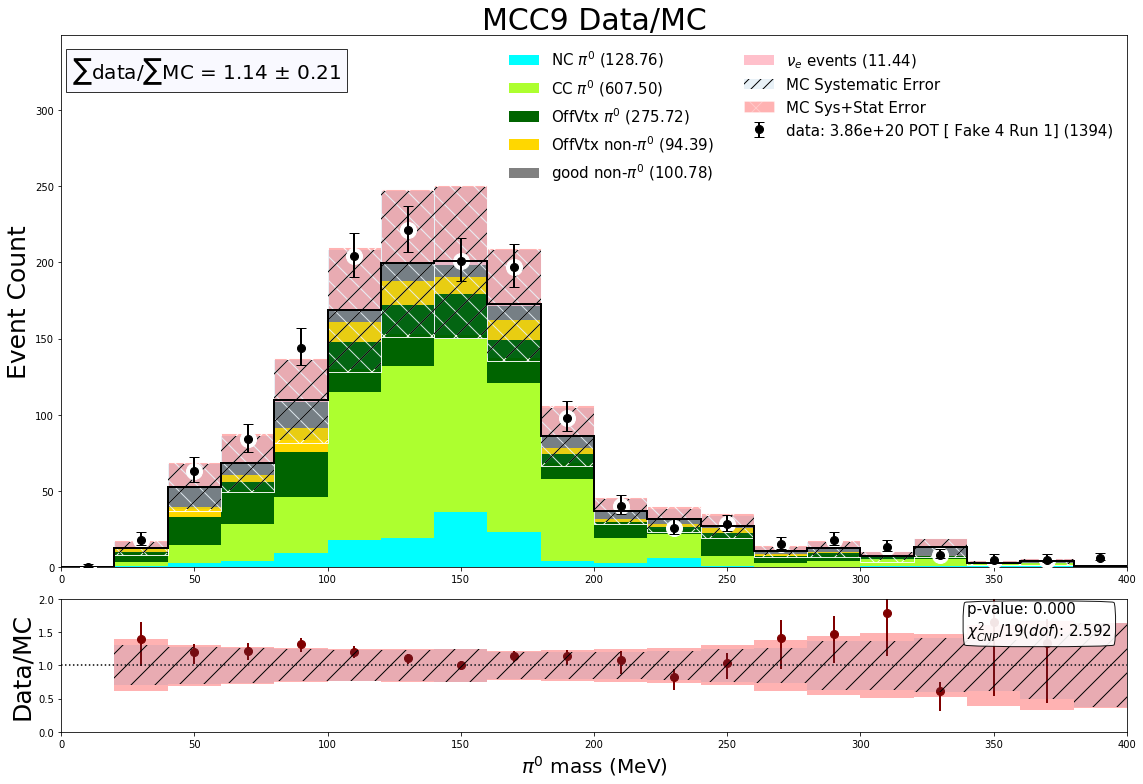

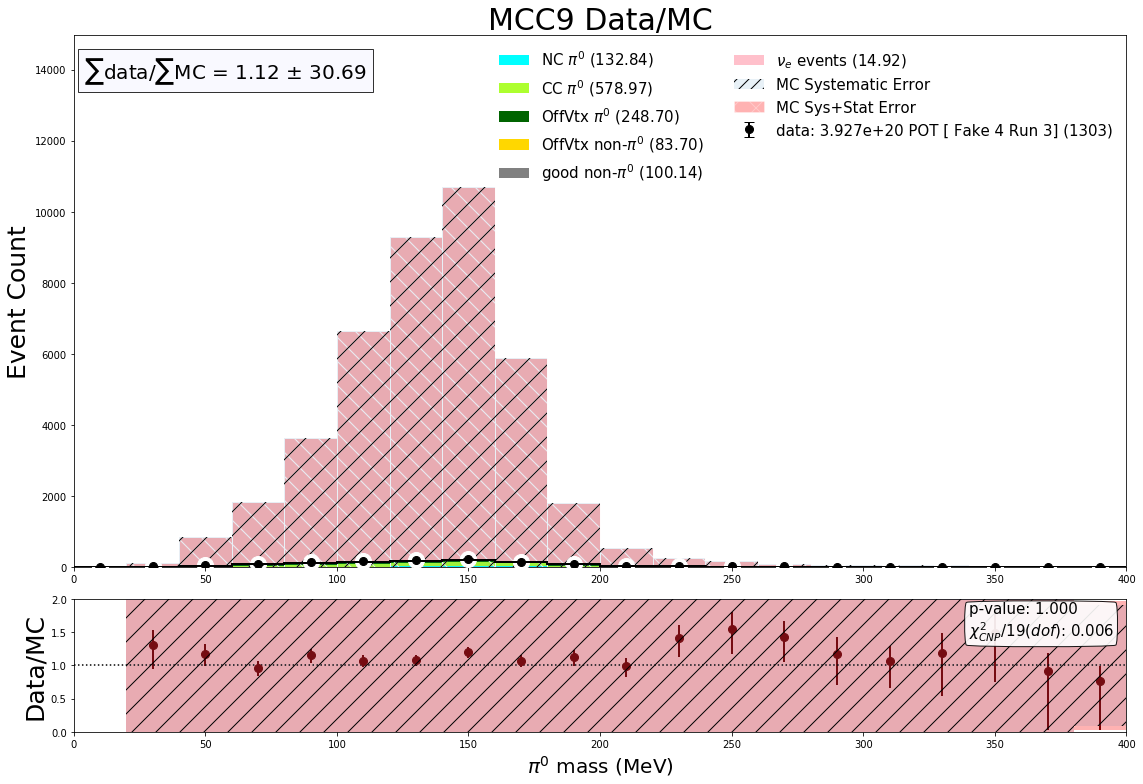

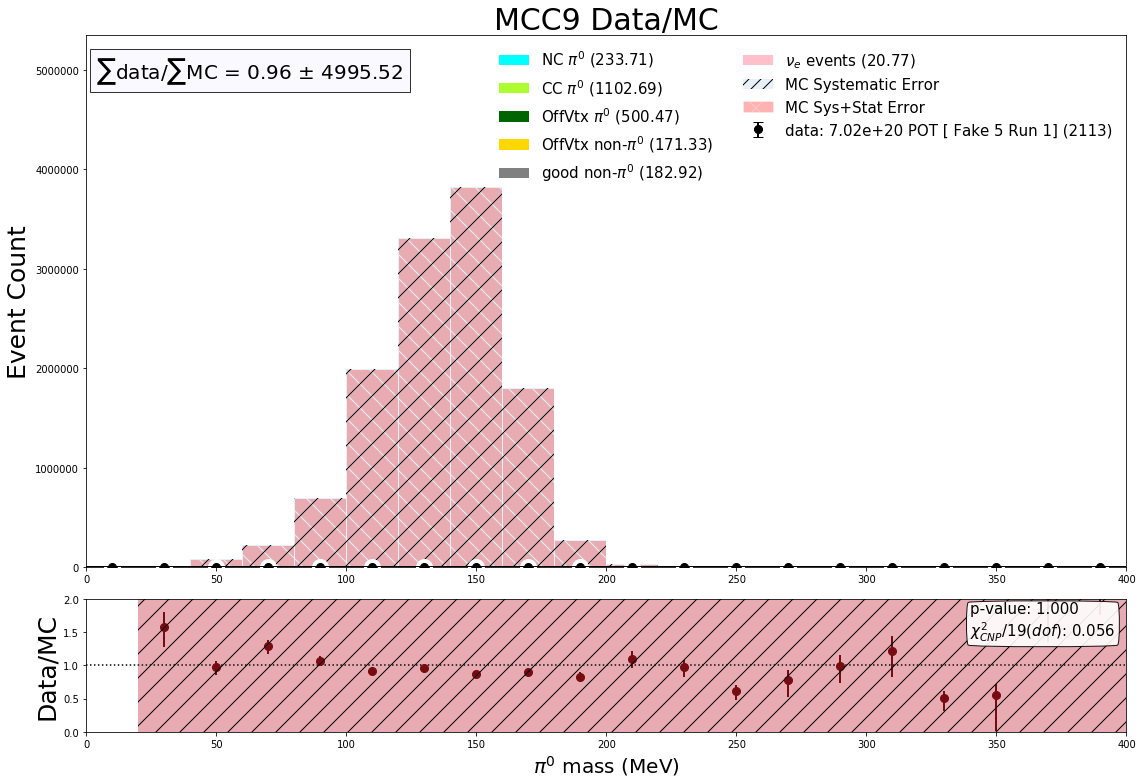

In [35]:
# plot all of the seperate pi0 mass distributions
vartest = '_pi0mass'
varname = r'$\pi^0$ mass (MeV)'
myrange = (0,400)
nbins = 20
norm = 1.0
# norm = (len(df_numu_pi0)*NUMU_SCALE+ len(df_nue_pi0)*NUE_SCALE +len(df_ext_pi0)*EXT_SCALE)/len(df_data_pi0)
print("DATA/MC: ",1.0/norm)

# s_cov = np.genfromtxt('../systematics/covar_run1_full__pi0_mass_reco.txt',delimiter=',')
# run1_fake1_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_pi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NUMU_R1_FAKE1_SCALE*norm,NUMU_R1_FAKE1_SCALE*norm,NUMU_R1_FAKE1_SCALE*norm,NUMU_R1_FAKE1_SCALE*norm,NUMU_R1_FAKE1_SCALE*norm,NUE_R1_FAKE1_SCALE*norm))
# run1_fake1_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# run1_fake1_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# run1_fake1_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# run1_fake1_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# run1_fake1_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# run1_fake1_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# run1_fake1_DataHist = SimpleHisto(df_fakedata1_run1_pi0,1.0,0,'','data: 1.925e20 POT [ Fake 1 Run 1]')
# fig1,ax1,_,p = distplot_wratio_davio(vartest,nbins,myrange,run1_fake1_Hists,run1_fake1_DataHist,varname,m_cov = s_cov)

# s_cov = np.genfromtxt('../systematics/covar_run3_full__pi0_mass_reco.txt',delimiter=',')
# run3_fake1_Hists = StackedHisto((df_bnb_ncpi0_r3,df_bnb_ccpi0_r3,df_bnb_pi0_offvtx_r3,df_bnb_other_offvtx_r3,df_bnb_other_good_r3,df_nue_r3_pi0),(NUMU_R3_FAKE1_SCALE*norm,NUMU_R3_FAKE1_SCALE*norm,NUMU_R3_FAKE1_SCALE*norm,NUMU_R3_FAKE1_SCALE*norm,NUMU_R3_FAKE1_SCALE*norm,NUE_R3_FAKE1_SCALE*norm))
# run3_fake1_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# run3_fake1_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# run3_fake1_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# run3_fake1_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# run3_fake1_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# run3_fake1_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# run3_fake1_DataHist = SimpleHisto(df_fakedata1_run3_pi0,1.0,0,'','data: 2.83e20 POT [ Fake 1 Run 3]')
# fig2,ax2,_,p = distplot_wratio_davio(vartest,nbins,myrange,run3_fake1_Hists,run3_fake1_DataHist,varname,m_cov =s_cov)

# s_cov = np.genfromtxt('../systematics/covar_run1_full__pi0_mass_reco.txt',delimiter=',')
# run1_fake2_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_pi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NUMU_R1_FAKE2_SCALE*norm,NUMU_R1_FAKE2_SCALE*norm,NUMU_R1_FAKE2_SCALE*norm,NUMU_R1_FAKE2_SCALE*norm,NUMU_R1_FAKE2_SCALE*norm,NUE_R1_FAKE2_SCALE*norm))
# run1_fake2_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# run1_fake2_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# run1_fake2_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# run1_fake2_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# run1_fake2_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# run1_fake2_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# run1_fake2_DataHist = SimpleHisto(df_fakedata2_run1_pi0,1.0,0,'','data: 3.617e+20 POT [ Fake 2 Run 1]')
# fig3,ax3,_,q = distplot_wratio_davio(vartest,nbins,myrange,run1_fake2_Hists,run1_fake2_DataHist,varname,m_cov=s_cov)

# s_cov = np.genfromtxt('../systematics/covar_run3_full__pi0_mass_reco.txt',delimiter=',')
# run3_fake2_Hists = StackedHisto((df_bnb_ncpi0_r3,df_bnb_ccpi0_r3,df_bnb_pi0_offvtx_r3,df_bnb_other_offvtx_r3,df_bnb_other_good_r3,df_nue_r3_pi0),(NUMU_R3_FAKE2_SCALE*norm,NUMU_R3_FAKE2_SCALE*norm,NUMU_R3_FAKE2_SCALE*norm,NUMU_R3_FAKE2_SCALE*norm,NUMU_R3_FAKE2_SCALE*norm,NUE_R3_FAKE2_SCALE*norm))
# run3_fake2_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# run3_fake2_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# run3_fake2_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# run3_fake2_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# run3_fake2_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# run3_fake2_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# run3_fake2_DataHist = SimpleHisto(df_fakedata2_run3_pi0,1.0,0,'','data: 3.841e+20 POT [ Fake 2 Run 3]')
# fig2,ax2,_,a = distplot_wratio_davio(vartest,nbins,myrange,run3_fake2_Hists,run3_fake2_DataHist,varname,m_cov=s_cov)

# s_cov = np.genfromtxt('../systematics/covar_run1_full__pi0_mass_reco.txt',delimiter=',')
# run1_fake3_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_pi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NUMU_R1_FAKE3_SCALE*norm,NUMU_R1_FAKE3_SCALE*norm,NUMU_R1_FAKE3_SCALE*norm,NUMU_R1_FAKE3_SCALE*norm,NUMU_R1_FAKE3_SCALE*norm,NUE_R1_FAKE3_SCALE*norm))
# run1_fake3_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# run1_fake3_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# run1_fake3_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# run1_fake3_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# run1_fake3_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# run1_fake3_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# run1_fake3_DataHist = SimpleHisto(df_fakedata3_run1_pi0,1.0,0,'','data: 3.840e+20 POT [ Fake 3 Run 1]')
# fig4,ax4,_, p= distplot_wratio_davio(vartest,nbins,myrange,run1_fake3_Hists,run1_fake3_DataHist,varname,m_cov=s_cov)

# s_cov = np.genfromtxt('../systematics/covar_run3_full__pi0_mass_reco.txt',delimiter=',')
# run3_fake3_Hists = StackedHisto((df_bnb_ncpi0_r3,df_bnb_ccpi0_r3,df_bnb_pi0_offvtx_r3,df_bnb_other_offvtx_r3,df_bnb_other_good_r3,df_nue_r3_pi0),(NUMU_R3_FAKE3_SCALE*norm,NUMU_R3_FAKE3_SCALE*norm,NUMU_R3_FAKE3_SCALE*norm,NUMU_R3_FAKE3_SCALE*norm,NUMU_R3_FAKE3_SCALE*norm,NUE_R3_FAKE3_SCALE*norm))
# run3_fake3_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# run3_fake3_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# run3_fake3_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# run3_fake3_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# run3_fake3_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# run3_fake3_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# run3_fake3_DataHist = SimpleHisto(df_fakedata3_run3_pi0,1.0,0,'','data: 3.968e+20 POT [ Fake 3 Run 3]')
# fig2,ax2,_, p = distplot_wratio_davio(vartest,nbins,myrange,run3_fake3_Hists,run3_fake3_DataHist,varname,m_cov = s_cov)
s_cov = np.genfromtxt('../systematics/covar_cv_weighted__pi0_mass_reco.txt',delimiter=',')
d_cov = np.genfromtxt('../systematics/detvar_pi0mass_cov.txt',delimiter=',')
cov = s_cov+d_cov

run1_fake4_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_pi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NUMU_R1_FAKE4_SCALE*norm,NUMU_R1_FAKE4_SCALE*norm,NUMU_R1_FAKE4_SCALE*norm,NUMU_R1_FAKE4_SCALE*norm,NUMU_R1_FAKE4_SCALE*norm,NUE_R1_FAKE4_SCALE*norm))
run1_fake4_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run1_fake4_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run1_fake4_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run1_fake4_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run1_fake4_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run1_fake4_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run1_fake4_DataHist = SimpleHisto(df_fakedata4_run1_pi0,1.0,0,'','data: 3.86e+20 POT [ Fake 4 Run 1]')
fig7,ax7,_, p= distplot_wratio_davio(vartest,nbins,myrange,run1_fake4_Hists,run1_fake4_DataHist,varname,m_cov=cov)

run3_fake4_Hists = StackedHisto((df_bnb_ncpi0_r3,df_bnb_ccpi0_r3,df_bnb_pi0_offvtx_r3,df_bnb_other_offvtx_r3,df_bnb_other_good_r3,df_nue_r3_pi0),(NUMU_R3_FAKE4_SCALE*norm,NUMU_R3_FAKE4_SCALE*norm,NUMU_R3_FAKE4_SCALE*norm,NUMU_R3_FAKE4_SCALE*norm,NUMU_R3_FAKE4_SCALE*norm,NUE_R3_FAKE4_SCALE*norm))
run3_fake4_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run3_fake4_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run3_fake4_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run3_fake4_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run3_fake4_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run3_fake4_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run3_fake4_DataHist = SimpleHisto(df_fakedata4_run3_pi0,1.0,0,'','data: 3.927e+20 POT [ Fake 4 Run 3]')
fig8,ax8,_, p = distplot_wratio_davio(vartest,nbins,myrange,run3_fake4_Hists,run3_fake4_DataHist,varname,m_cov = cov)



run1_fake5_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_pi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NUMU_R1_FAKE5_SCALE*norm,NUMU_R1_FAKE5_SCALE*norm,NUMU_R1_FAKE5_SCALE*norm,NUMU_R1_FAKE5_SCALE*norm,NUMU_R1_FAKE5_SCALE*norm,NUE_R1_FAKE5_SCALE*norm))
run1_fake5_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
run1_fake5_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
run1_fake5_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
run1_fake5_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
run1_fake5_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
run1_fake5_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
run1_fake5_DataHist = SimpleHisto(df_fakedata5_run1_pi0,1.0,0,'','data: 7.02e+20 POT [ Fake 5 Run 1]')
fig9,ax9,_, p= distplot_wratio_davio(vartest,nbins,myrange,run1_fake5_Hists,run1_fake5_DataHist,varname,m_cov=cov)

In [36]:
# plot all of the seperate pi0  distributions
vartest_list = []
varname_list = []
myrange_list = []
cov_list=[]
vartest_list.append('_pi0mass_new')
varname_list.append('Pi0 mass (MeV)')
myrange_list.append((0.0,400.0))
cov_list.append(np.genfromtxt('../systematics/covar_cv_weighted__pi0_mass_reco.txt',delimiter=','))
# vartest_list.append('_shower_alpha')
# varname_list.append('Angle between showers (radian)')
# myrange_list.append((0.0,3.1415))
# vartest_list.append('DeltaMass')
# varname_list.append('Delta mass (MeV)')
# myrange_list.append((1000.0,1400.0))
vartest_list.append('pi0_energy_reco_new')
varname_list.append('Pi0 Energy (MeV)')
myrange_list.append((100.0,800.0))
cov_list.append(np.genfromtxt('../systematics/covar_cv_weighted__pi0_energy_reco.txt',delimiter=','))
vartest_list.append('pi0_momentum_reco_new')
varname_list.append('Pi0 Momentum (MeV)')
myrange_list.append((100.0,800.0))
cov_list.append(np.genfromtxt('../systematics/covar_cv_weighted__pi0_momentum_reco.txt',delimiter=','))
vartest_list.append('shower1_E_Y_new')
varname_list.append('shower1 energy (MeV)')
myrange_list.append((80.0,450.0))
cov_list.append(np.genfromtxt('../systematics/covar_cv_weighted__shower1_energy_reco.txt',delimiter=','))
vartest_list.append('shower2_E_Y_new')
varname_list.append('shower2 energy (MeV)')
myrange_list.append((35.0,350.0))
cov_list.append(np.genfromtxt('../systematics/covar_cv_weighted__shower2_energy_reco.txt',delimiter=','))
# vartest_list.append('shower1_dir_3d_X')
# varname_list.append('shower1 3d X direction component')
# myrange_list.append((-80.0,80.0))
# vartest_list.append('shower1_dir_3d_Y')
# varname_list.append('shower1 3d Y direction component')
# myrange_list.append((-80.0,80.0))
# vartest_list.append('shower1_dir_3d_Z')
# varname_list.append('shower1 3d Z direction component')
# myrange_list.append((-80.0,80.0))
# vartest_list.append('shower2_dir_3d_X')
# varname_list.append('shower2 3d X direction component')
# myrange_list.append((-80.0,80.0))
# vartest_list.append('shower2_dir_3d_Y')
# varname_list.append('shower2 3d Y direction component')
# myrange_list.append((-80.0,80.0))
# vartest_list.append('shower2_dir_3d_Z')
# varname_list.append('shower2 3d Z direction component')
# myrange_list.append((-80.0,80.0))
# vartest_list.append('shower1_op_2d_U')
# varname_list.append('shower1 opening angle U plane')
# myrange_list.append((0.05,0.3))
# vartest_list.append('shower1_op_2d_V')
# varname_list.append('shower1 opening angle V plane')
# myrange_list.append((0.05,0.3))
# vartest_list.append('shower1_op_2d_Y')
# varname_list.append('shower1 opening angle Y plane')
# myrange_list.append((0.05,0.3))
# vartest_list.append('shower2_op_2d_U')
# varname_list.append('shower2 opening angle U plane')
# myrange_list.append((0.05,0.3))
# vartest_list.append('shower2_op_2d_V')
# varname_list.append('shower2 opening angle V plane')
# myrange_list.append((0.05,0.3))
# vartest_list.append('shower2_op_2d_Y')
# varname_list.append('shower2 opening angle Y plane')
# myrange_list.append((0.05,0.3))
# vartest_list.append('_shower1_impact')
# varname_list.append('shower1 impact distance (cm)')
# myrange_list.append((0.0,100.0))
# vartest_list.append('_shower2_impact')
# varname_list.append('shower2 impact distance (cm)')
# myrange_list.append((0.0,100.0))
# vartest_list.append('shower1_start_2d_U_X')
# varname_list.append('shower1 start U Plane col')
# myrange_list.append((0.0,2500.0))
# vartest_list.append('shower1_start_2d_U_Y')
# varname_list.append('shower1 start U Plane row')
# myrange_list.append((0.0,1000.0))
# vartest_list.append('shower1_start_2d_V_X')
# varname_list.append('shower1 start V Plane col')
# myrange_list.append((0.0,2500.0))
# vartest_list.append('shower1_start_2d_V_Y')
# varname_list.append('shower1 start V Plane row')
# myrange_list.append((0.0,1000.0))
# vartest_list.append('shower1_start_2d_Y_X')
# varname_list.append('shower1 start Y Plane col')
# myrange_list.append((0.0,2500.0))
# vartest_list.append('shower1_start_2d_Y_Y')
# varname_list.append('shower1 start Y Plane row')
# myrange_list.append((0.0,1000.0))
# vartest_list.append('shower2_start_2d_U_X')
# varname_list.append('shower2 start U Plane col')
# myrange_list.append((0.0,2500.0))
# vartest_list.append('shower2_start_2d_U_Y')
# varname_list.append('shower2 start U Plane row')
# myrange_list.append((0.0,1000.0))
# vartest_list.append('shower2_start_2d_V_X')
# varname_list.append('shower2 start V Plane col')
# myrange_list.append((0.0,2500.0))
# vartest_list.append('shower2_start_2d_V_Y')
# varname_list.append('shower2 start V Plane row')
# myrange_list.append((0.0,1000.0))
# vartest_list.append('shower2_start_2d_Y_X')
# varname_list.append('shower2 start Y Plane col')
# myrange_list.append((0.0,2500.0))
# vartest_list.append('shower2_start_2d_Y_Y')
# varname_list.append('shower2 start Y Plane row')
# myrange_list.append((0.0,1000.0))

hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [1.48861591 1.48861591 1.48861591 ... 0.00716137 0.00716137 0.00716137]
Normalization Uncertainty: 0.21323549306964956
2.340999341801641 0.0008103412818674105


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:424: RuntimeWarning: divide by zero encountered in true_divide


hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [1.48861591 1.48861591 1.48861591 ... 0.00716137 0.00716137 0.00716137]
Normalization Uncertainty: 0.19942980161327722
1.225775670321611 0.22059829992376423
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [1.48861591 1.48861591 1.48861591 ... 0.00716137 0.00716137 0.00716137]
Normalization Uncertainty: 0.1916962531479816
1.692515269427171 0.027155322874987453
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [1.48861591 1.48861591 1.48861591 ... 0.00716137 0.00716137 0.00716137]
Normalization Uncertainty: 0.20020688354157035
0.6937080653681523 0.8368184793135611
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [1.48861591 1.48861591 1.48861591 ... 0.00716137 0.00716137 0.00716137]
Normalization Uncertainty: 0.2007712240012187
8.587356497642972 0.0


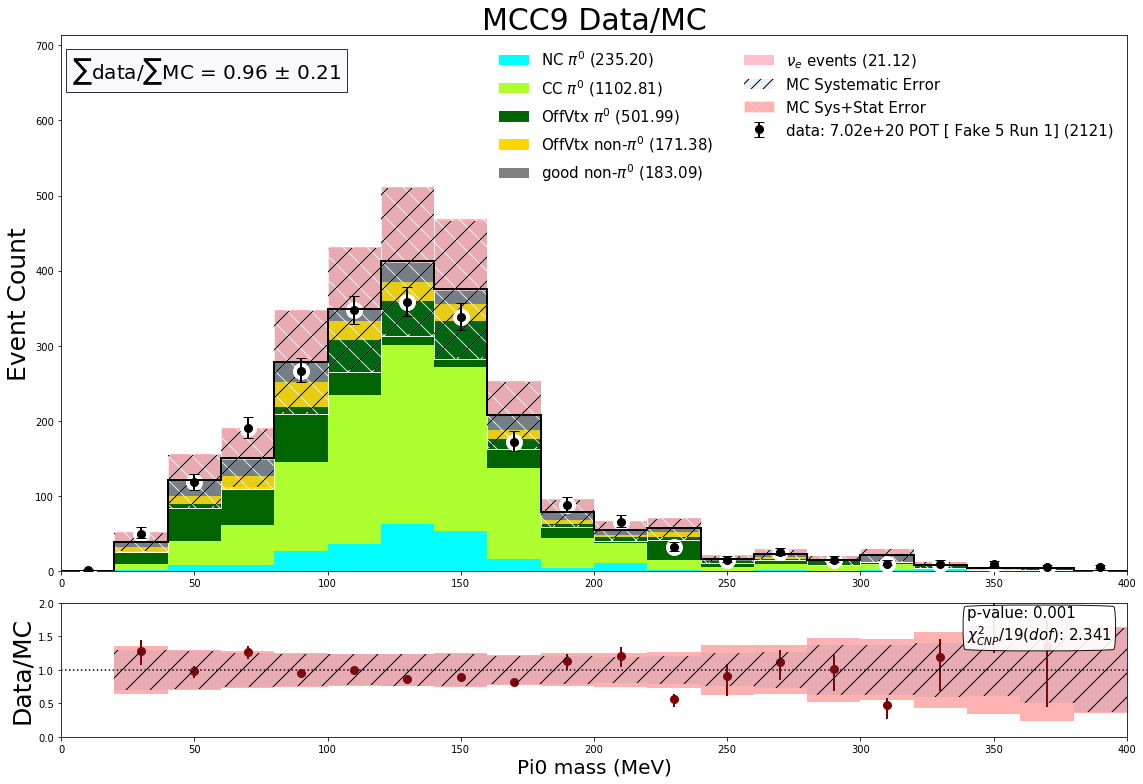

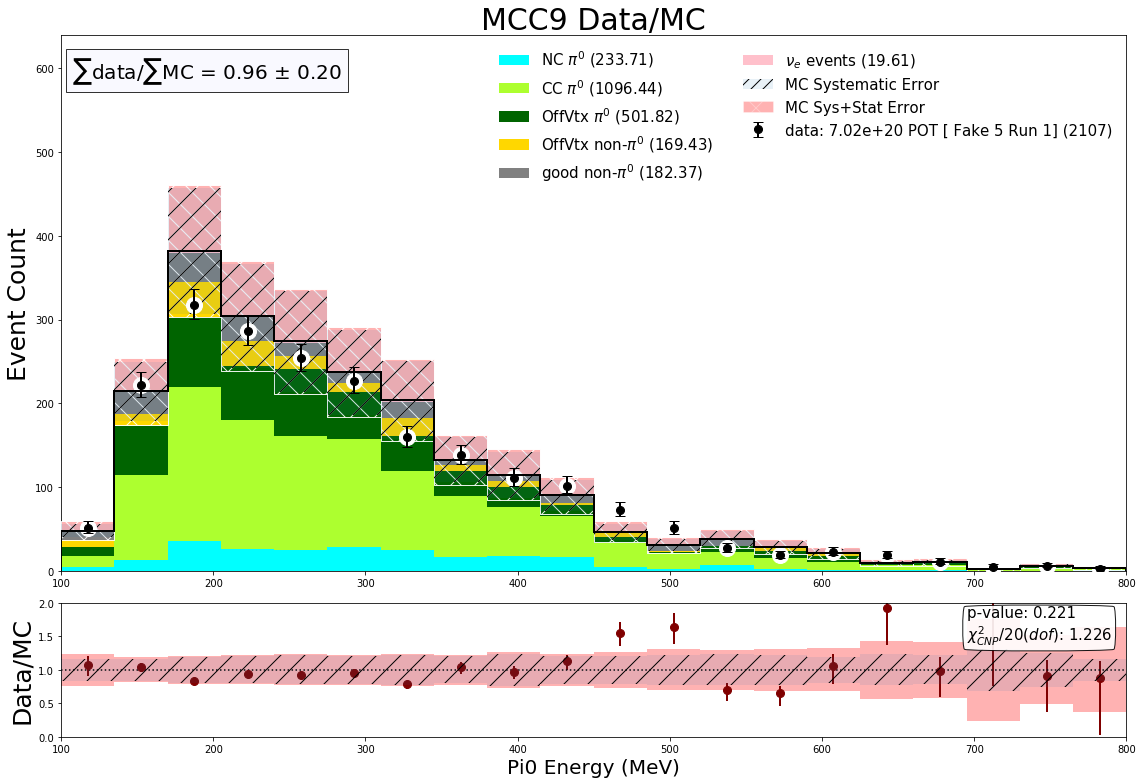

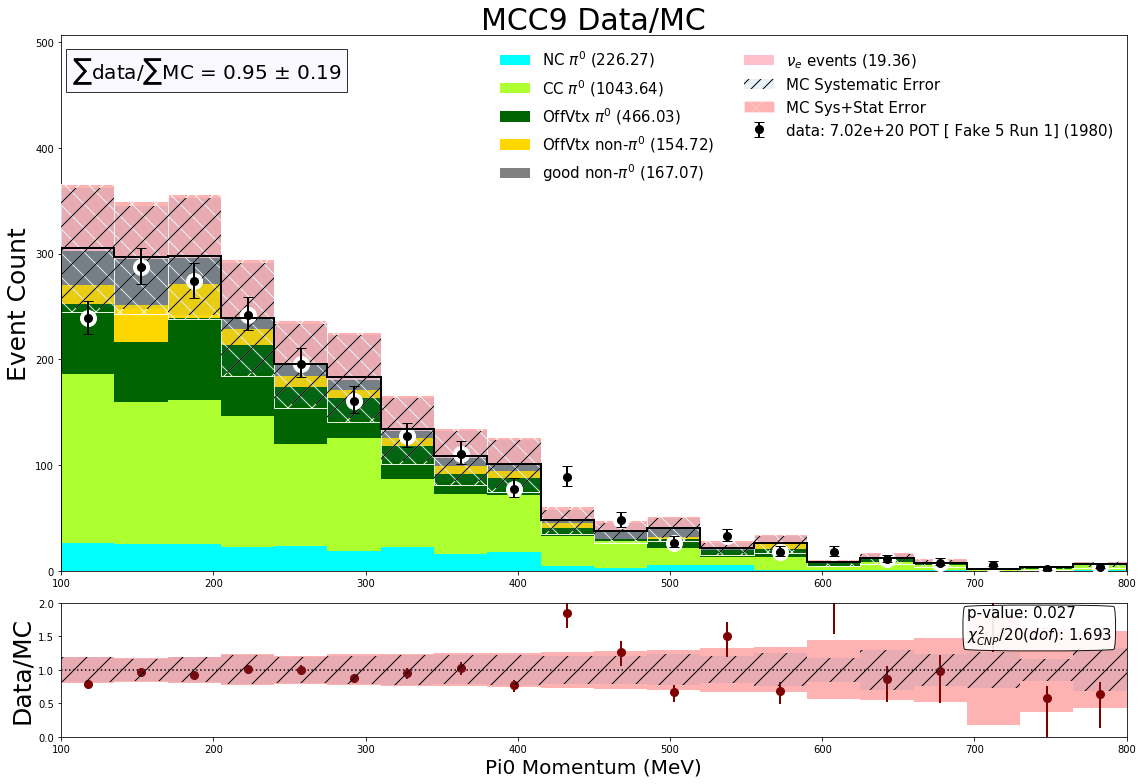

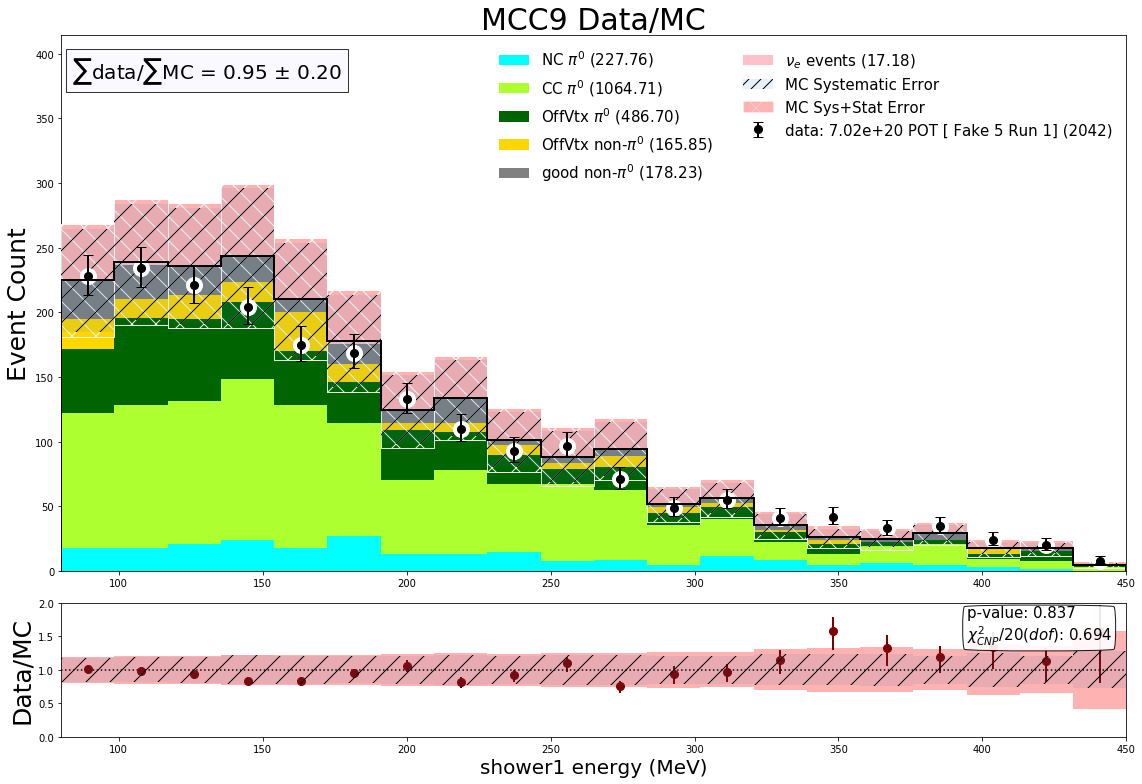

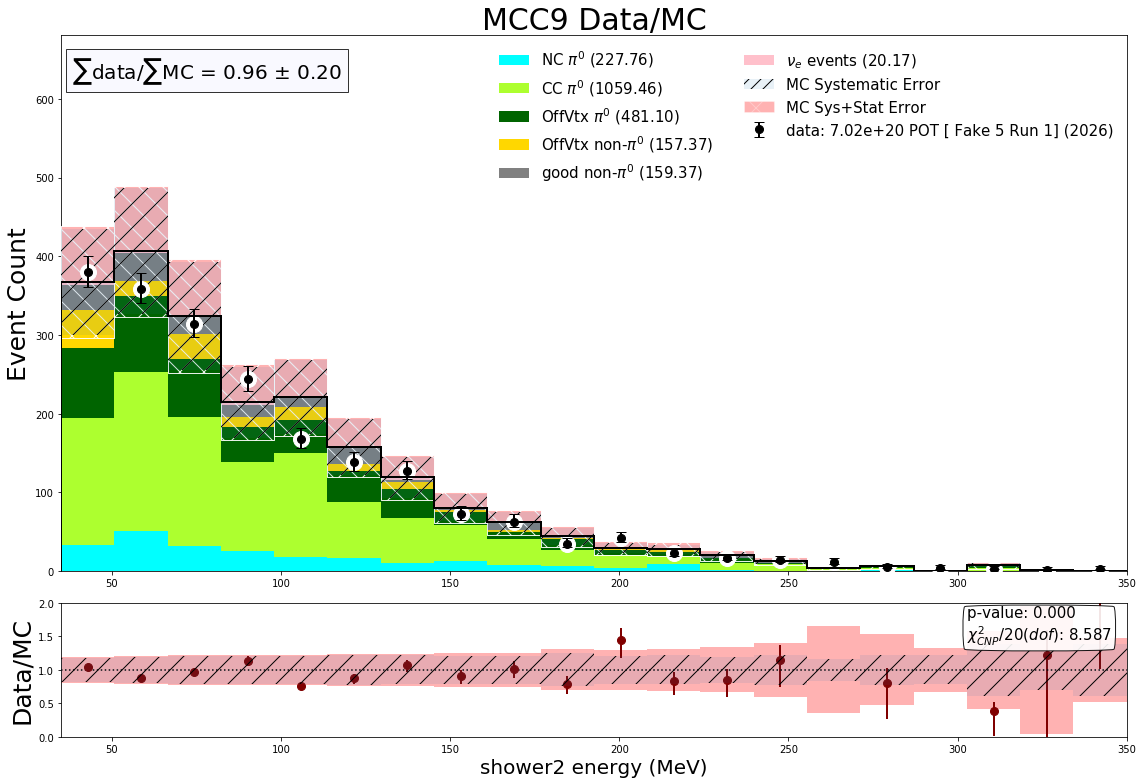

In [37]:
norm = 1.0

for i in range(len(vartest_list)):
    vartest = vartest_list[i]
    varname = varname_list[i]
    myrange = myrange_list[i]
    nbins =20
    cov = cov_list[i]
    if i==0:
        cov =cov_list[i]+np.genfromtxt('../systematics/detvar_pi0mass_cov.txt',delimiter=',')
    run1_fake5_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_pi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NUMU_R1_FAKE5_SCALE*norm,NUMU_R1_FAKE5_SCALE*norm,NUMU_R1_FAKE5_SCALE*norm,NUMU_R1_FAKE5_SCALE*norm,NUMU_R1_FAKE5_SCALE*norm,NUE_R1_FAKE5_SCALE*norm))
    run1_fake5_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
    run1_fake5_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
    run1_fake5_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
    run1_fake5_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
    run1_fake5_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
    run1_fake5_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
    run1_fake5_DataHist = SimpleHisto(df_fakedata5_run1_pi0,1.0,0,'','data: 7.02e+20 POT [ Fake 5 Run 1]')
    fig9,ax9,_, p= distplot_wratio_davio(vartest,nbins,myrange,run1_fake5_Hists,run1_fake5_DataHist,varname,m_cov=cov)

In [38]:
# add all of the data frames
# df_data_total_1 = df_fakedata1_run1_pi0.append(df_fakedata1_run3_pi0)
# df_data_total_2 = df_fakedata2_run1_pi0.append(df_fakedata2_run3_pi0)
# df_data_total_3 = df_fakedata3_run1_pi0.append(df_fakedata3_run3_pi0)
df_data_total_4 = df_fakedata4_run1_pi0.append(df_fakedata4_run3_pi0)

# print("total number of data pi0 1: ",len(df_data_total_1['_pi0mass'].values))
# print("total number of data pi0 2: ",len(df_data_total_2['_pi0mass'].values))
# print("total number of data pi0 3: ",len(df_data_total_3['_pi0mass'].values))
print("total number of data pi0 4: ",len(df_data_total_4['_pi0mass'].values))


# general mc 
df_numu_total = df_numu_pi0.append(df_numu_r3_pi0)
df_nue_total = df_nue_pi0.append(df_nue_r3_pi0)


#specific categories
df_bnb_ncpi0_total = df_numu_total.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
df_bnb_ccpi0_total = df_numu_total.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
df_bnb_pi0_offvtx_total = df_numu_total.query("haspi0==1 and MC_scedr>=5 ") 
df_bnb_other_offvtx_total = df_numu_total.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good_total = df_numu_total.query("haspi0==0 and MC_scedr<5")

total number of data pi0 4:  2707


In [46]:
NUMU_POT_TOTAL = NUMU_R1_POT+NUMU_R3_POT
NUE_POT_TOTAL = NUE_R1_POT+NUE_R3_POT

DATA_POT_TOTAL_1 = FAKE_DATA_1_RUN1_POT + FAKE_DATA_1_RUN3_POT
DATA_POT_TOTAL_2 = FAKE_DATA_2_RUN1_POT + FAKE_DATA_2_RUN3_POT
DATA_POT_TOTAL_3 = FAKE_DATA_3_RUN1_POT + FAKE_DATA_3_RUN3_POT
DATA_POT_TOTAL_4 = FAKE_DATA_4_RUN1_POT + FAKE_DATA_4_RUN3_POT

POT_SCALE_FACTOR_1 = DATA_POT_TOTAL_1 *1.0
POT_SCALE_FACTOR_2 = DATA_POT_TOTAL_2 *1.0
POT_SCALE_FACTOR_3 = DATA_POT_TOTAL_3 *1.0
POT_SCALE_FACTOR_4 = DATA_POT_TOTAL_4 *1.0

NUMU_SCALE_TOTAL_1 = POT_SCALE_FACTOR_1 / float(NUMU_POT_TOTAL)
NUMU_SCALE_TOTAL_2 = POT_SCALE_FACTOR_2 / float(NUMU_POT_TOTAL)
NUMU_SCALE_TOTAL_3 = POT_SCALE_FACTOR_3 / float(NUMU_POT_TOTAL)
NUMU_SCALE_TOTAL_4 = POT_SCALE_FACTOR_4 / float(NUMU_POT_TOTAL)
NUE_SCALE_TOTAL_1 = POT_SCALE_FACTOR_1/ float(NUE_POT_TOTAL)
NUE_SCALE_TOTAL_2 = POT_SCALE_FACTOR_2 / float(NUE_POT_TOTAL)
NUE_SCALE_TOTAL_3 = POT_SCALE_FACTOR_3 / float(NUE_POT_TOTAL)
NUE_SCALE_TOTAL_4 = POT_SCALE_FACTOR_4 / float(NUE_POT_TOTAL)
DATA_SCALE_TOTAL_1 = POT_SCALE_FACTOR_1 / float(DATA_POT_TOTAL_1)
DATA_SCALE_TOTAL_2 = POT_SCALE_FACTOR_2 / float(DATA_POT_TOTAL_2)
DATA_SCALE_TOTAL_3 = POT_SCALE_FACTOR_3 / float(DATA_POT_TOTAL_3)
DATA_SCALE_TOTAL_4 = POT_SCALE_FACTOR_4 / float(DATA_POT_TOTAL_4)

norm:  1.0
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.56882605 0.56882605 0.56882605 ... 0.00537224 0.00537224 0.00537224]
Normalization Uncertainty: 0.2007468833559474
0.45983544224749484 0.9775988354289821


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:424: RuntimeWarning: invalid value encountered in true_divide


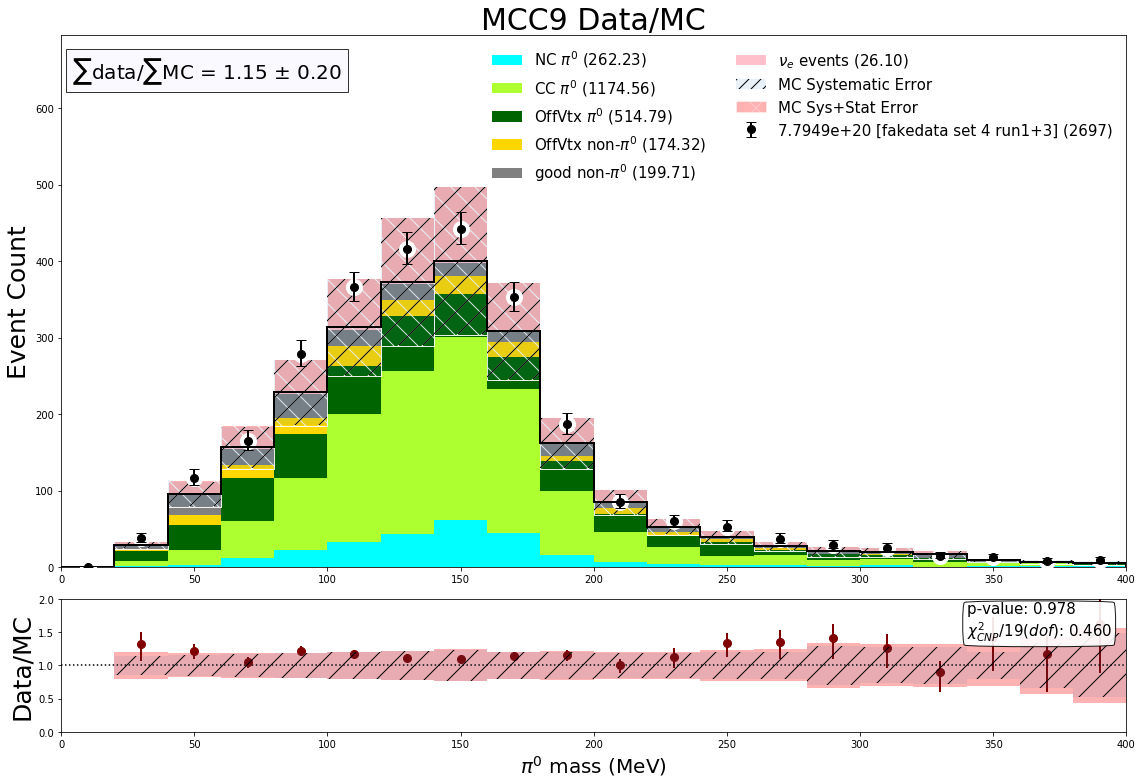

In [48]:
vartest = '_pi0mass'
varname = r'$\pi^0$ mass (MeV)'
myrange = (0,400)
nbins = 20
cov = np.genfromtxt('../systematics/covar_cv_weighted__pi0_mass_reco.txt',delimiter=',')
# norm = (len(df_numu_total)*NUMU_SCALE_TOTAL+ len(df_nue_total)*NUE_SCALE_TOTAL +len(df_ext_total)*EXT_SCALE_TOTAL)/len(df_data_total)
# norm = 1.0/norm
print("norm: ",norm)
norm = 1.0
# # s_cov = np.genfromtxt('../systematics/covar_comb_full__pi0_mass_reco.txt',delimiter=',')
# set1Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUE_SCALE_TOTAL_1*norm))
# set1Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# set1Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# set1Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# set1Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# set1Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# set1Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# # d_cov = np.genfromtxt('../systematics/detvar_pi0mass_cov.txt',delimiter=',')
# # cov = s_cov+d_cov
# set1DataHist = SimpleHisto(df_data_total_1,DATA_SCALE_TOTAL_1,0,'','4.7e20 POT [fakedata set 1 run1+3]')
# fig,ax0,_,p = distplot_wratio_davio(vartest,nbins,myrange,set1Hists,set1DataHist,varname,m_cov=cov)

# s_cov = np.genfromtxt('../systematics/covar_comb_full__pi0_mass_reco.txt',delimiter=',')
# set2Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_2*norm,NUMU_SCALE_TOTAL_2*norm,NUMU_SCALE_TOTAL_2*norm,NUMU_SCALE_TOTAL_2*norm,NUMU_SCALE_TOTAL_2*norm,NUE_SCALE_TOTAL_2*norm))
# set2Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# set2Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# set2Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# set2Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# set2Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# set2Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# set2DataHist = SimpleHisto(df_data_total_2,DATA_SCALE_TOTAL_2,0,'','7.458e+20 POT [fakedata set 2 run1+3]')
# d_cov = np.genfromtxt('../systematics/detvar_pi0mass_cov.txt',delimiter=',')
# cov = s_cov+d_cov
# fig2,ax02,_,p = distplot_wratio_davio(vartest,nbins,myrange,set2Hists,set2DataHist,varname,m_cov=cov)

# s_cov = np.genfromtxt('../systematics/covar_comb_full__pi0_mass_reco.txt',delimiter=',')
# set3Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUE_SCALE_TOTAL_3*norm))
# set3Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# set3Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# set3Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# set3Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# set3Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# set3Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# set3DataHist = SimpleHisto(df_data_total_3,DATA_SCALE_TOTAL_3,0,'','7.8e20 POT [fakedata set 3 run1+3]')
# d_cov = np.genfromtxt('../systematics/detvar_pi0mass_cov.txt',delimiter=',')
# cov = s_cov+d_cov
# fig3,ax03,_,p = distplot_wratio_davio(vartest,nbins,myrange,set3Hists,set3DataHist,varname,m_cov=cov)

# s_cov = np.genfromtxt('../systematics/covar_comb_full__pi0_mass_reco.txt',delimiter=',')
set4Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_4*norm,NUMU_SCALE_TOTAL_4*norm,NUMU_SCALE_TOTAL_4*norm,NUMU_SCALE_TOTAL_4*norm,NUMU_SCALE_TOTAL_4*norm,NUE_SCALE_TOTAL_4*norm))
set4Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set4Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set4Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set4Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set4Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set4Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set4DataHist = SimpleHisto(df_data_total_4,DATA_SCALE_TOTAL_4,0,'','7.7949e+20 [fakedata set 4 run1+3]')

fig3,ax03,_,p = distplot_wratio_davio(vartest,nbins,myrange,set4Hists,set4DataHist,varname,m_cov=cov)


In [27]:
vartest = 'DeltaMass'
varname = r'Delta mass (MeV)'
myrange = (1000,1400)
nbins = 10
# norm = (len(df_numu_total)*NUMU_SCALE_TOTAL+ len(df_nue_total)*NUE_SCALE_TOTAL +len(df_ext_total)*EXT_SCALE_TOTAL)/len(df_data_total)
# norm = 1.0/norm
print("norm: ",norm)
norm = 1.0
set1Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUE_SCALE_TOTAL_1*norm))
set1Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set1Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set1Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set1Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set1Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set1Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set1DataHist = SimpleHisto(df_data_total_1,DATA_SCALE_TOTAL_1,0,'','4.7e20 POT [fakedata set 1 run1+3]')
fig,ax0,_ = distplot_wratio_davio(vartest,nbins,myrange,set1Hists,set1DataHist,varname,s_cov ='../systematics/covar_comb_full__Delta_mass_reco.txt')

set3Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUE_SCALE_TOTAL_3*norm))
set3Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set3Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set3Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set3Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set3Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set3Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set3DataHist = SimpleHisto(df_data_total_3,DATA_SCALE_TOTAL_3,0,'','7.8e20 POT [fakedata set 3 run1+3]')
fig3,ax03,_ = distplot_wratio_davio(vartest,nbins,myrange,set3Hists,set3DataHist,varname,s_cov ='../systematics/covar_comb_full__Delta_mass_reco.txt')


norm:  1.0


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



TypeError: distplot_wratio_davio() got an unexpected keyword argument 's_cov'

norm:  1.0
[19.17574913 18.08011435 17.77365088 23.61756603 20.82546945 18.19343098
 19.9297702  15.80273008 14.16228156 11.9562825  13.41495573  7.6029401
  9.39250956  6.026292    6.53592718  4.76674611  3.65115837  2.54912352
  2.92379007  1.56750193]
[20.20286841 19.17710145 18.91758967 24.5123318  21.7405615  19.06395337
 20.72391113 16.60985583 14.92058201 12.65585642 14.02580103  8.43146354
  9.98790677  6.74433617  7.1162772   5.29348447  4.17819115  3.24775846
  3.48735436  2.1205693 ]
sqdata 107.67295364413863 0
sqdata 113.18690423617069 1
sqdata 112.22577512755625 2
sqdata 119.60422411135175 3
sqdata 104.61911524194151 4
sqdata 91.34501200480607 5
sqdata 83.85951528013922 6
sqdata 70.38738968731775 7
sqdata 61.77439746116336 8
sqdata 45.90608969909246 9
sqdata 48.38373130378138 10
sqdata 34.48574398444428 11
sqdata 26.157103231756587 12
sqdata 24.682748824841926 13
sqdata 22.103414420776335 14
sqdata 14.677882583665408 15
sqdata 11.842325014984318 16
sqdata 10.79722757137786

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:112: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



errboxes 20
mc: [116.89438302 118.41712937 121.78377722 125.06396192 113.08100086
  94.27465841  93.97894718  76.25488405  64.47463916  50.36542485
  49.10660737  39.00294215  33.82032136  27.05505794  23.3302437
  15.69044918  12.31378923  11.99486675  10.71723816   6.21440873]
data:  [ 93. 104.  97. 110.  91.  86.  69.  61.  57.  39.  47.  28.  18.  21.
  20.  13.  11.   9.   7.   4.]
Events: 985.0
Min Bin ct (data): 4.0
[31.48774957 29.68865044 29.18541874 38.78148382 34.19669095 29.87472327
 32.72589815 25.94904657 23.25533006 19.63294506 22.02817547 12.48449133
 15.42307353  9.895539   10.73239105  7.82728783  5.99542473  4.18581628
  4.80104162  2.57393377]
[33.17434207 31.48997017 31.063836   40.25074378 35.69932791 31.30417412
 34.029926   27.27439628 24.50050565 20.7816881  23.0312207  13.84497735
 16.40075207 11.07461132 11.68536118  8.69222434  6.86084469  5.33301747
  5.72644855  3.48210412]
sqdata 197.90431133154092 0
sqdata 206.31548902758053 1
sqdata 205.04674318974799 2

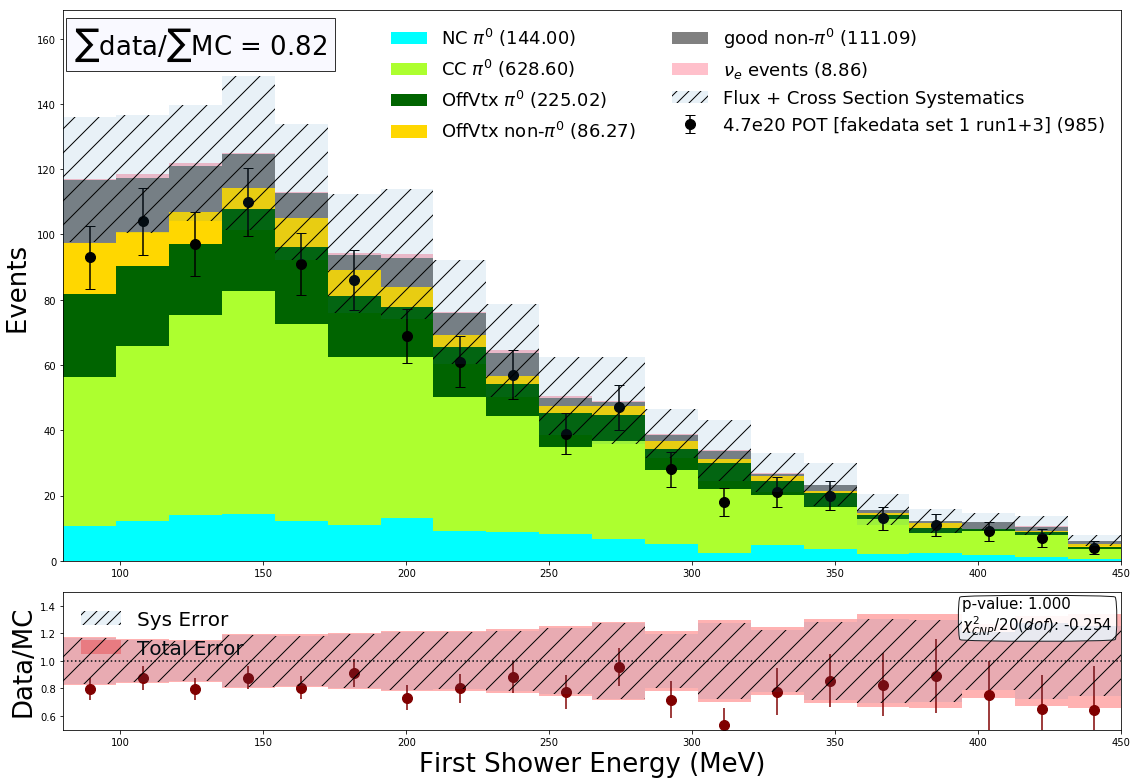

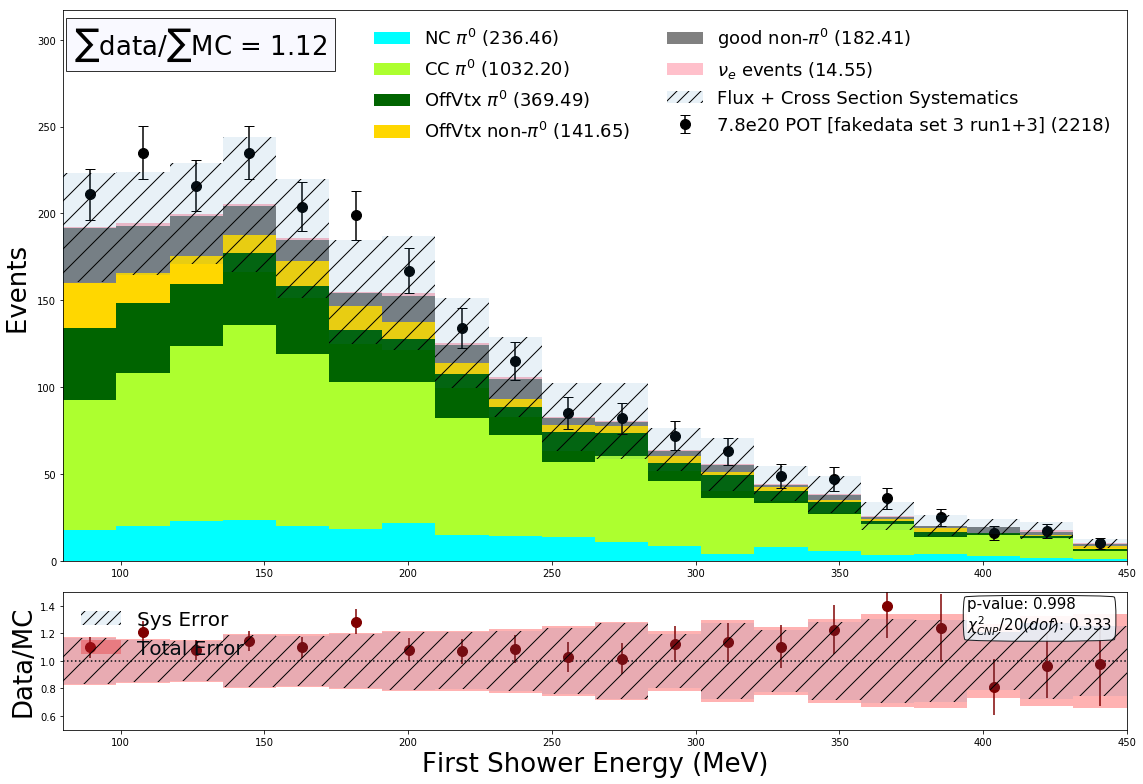

In [20]:
vartest = 'shower1_E_Y'
varname = r'First Shower Energy (MeV)'
myrange = (80,450)
nbins = 20
# norm = (len(df_numu_total)*NUMU_SCALE_TOTAL+ len(df_nue_total)*NUE_SCALE_TOTAL +len(df_ext_total)*EXT_SCALE_TOTAL)/len(df_data_total)
# norm = 1.0/norm
print("norm: ",norm)
norm = 1.0
set1Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUE_SCALE_TOTAL_1*norm))
set1Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set1Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set1Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set1Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set1Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set1Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set1DataHist = SimpleHisto(df_data_total_1,DATA_SCALE_TOTAL_1,0,'','4.7e20 POT [fakedata set 1 run1+3]')
fig,ax0,_ = distplot_wratio_davio(vartest,nbins,myrange,set1Hists,set1DataHist,varname,s_cov ='../systematics/covar_comb_full__shower1_energy_reco.txt')

set3Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUE_SCALE_TOTAL_3*norm))
set3Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set3Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set3Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set3Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set3Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set3Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set3DataHist = SimpleHisto(df_data_total_3,DATA_SCALE_TOTAL_3,0,'','7.8e20 POT [fakedata set 3 run1+3]')
fig3,ax03,_ = distplot_wratio_davio(vartest,nbins,myrange,set3Hists,set3DataHist,varname,s_cov ='../systematics/covar_comb_full__shower1_energy_reco.txt')


norm:  1.0
[35.69477519 32.18228466 26.62176141 29.59173188 22.34450523 18.43668162
 16.0759924  10.49941182  7.12586908  5.78466872  5.4867744   3.0403269
  3.26642629  1.28087982  1.79787816  1.14260729  0.94927329  0.52905571
  0.32887186  0.36001489]
[36.72300454 33.28674401 27.77434593 30.48848482 23.25764873 19.30370434
 16.86184588 11.29288468  7.85920828  6.4588982   6.0761067   3.81344859
  3.8249771   1.88884862  2.3238286   1.60773619  1.40890119  1.05967824
  0.70909509  0.78188928]
sqdata 199.927976082995 0
sqdata 209.84537853900207 1
sqdata 169.72456704724502 2
sqdata 145.80243561973978 3
sqdata 106.71608641936129 4
sqdata 86.14848502708858 5
sqdata 68.76891150026185 6
sqdata 43.54930795728422 7
sqdata 31.94597491031782 8
sqdata 24.24389844362429 9
sqdata 17.543213576968725 10
sqdata 14.623137028490762 11
sqdata 12.673705607811737 12
sqdata 6.345244968796342 13
sqdata 4.651331952980293 14
sqdata 4.099677485733907 15
sqdata 2.667356864349496 16
sqdata 1.6635377362593615 17

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:112: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



errboxes 20
mc: [217.59351847 210.78040169 182.41039403 156.699434   121.32927044
  95.5351337   75.80643561  50.66412112  32.44094786  24.36771611
  20.08481293  15.59682077  11.7616688    5.7505142    6.41759532
   3.76106072   3.20149114   2.48946458   1.20548944   1.42728991]
data:  [172. 208. 149. 128.  86.  72.  58.  34.  31.  24.  14.  13.  15.   8.
   3.   5.   2.   1.   1.   1.]
Events: 1025.0
Min Bin ct (data): 1.0
[58.61299783 52.84527415 43.71455585 48.5914285  36.69104035 30.27415564
 26.39775998 17.24067455 11.70111163  9.49877884  9.0096182   4.99240219
  5.36367118  2.10328278  2.95222559  1.87623085  1.55876463  0.86874174
  0.54002766  0.59116641]
[60.30141314 54.65886377 45.60716993 50.06395152 38.19047766 31.69785983
 27.68817931 18.54360537 12.90529931 10.60590476  9.97733777  6.26191517
  6.28084567  3.10160463  3.81586828  2.64000087  2.31350168  1.7400563
  1.16437738  1.28390988]
sqdata 367.8700709065117 0
sqdata 369.6909171631174 1
sqdata 318.0671387873364 2
s

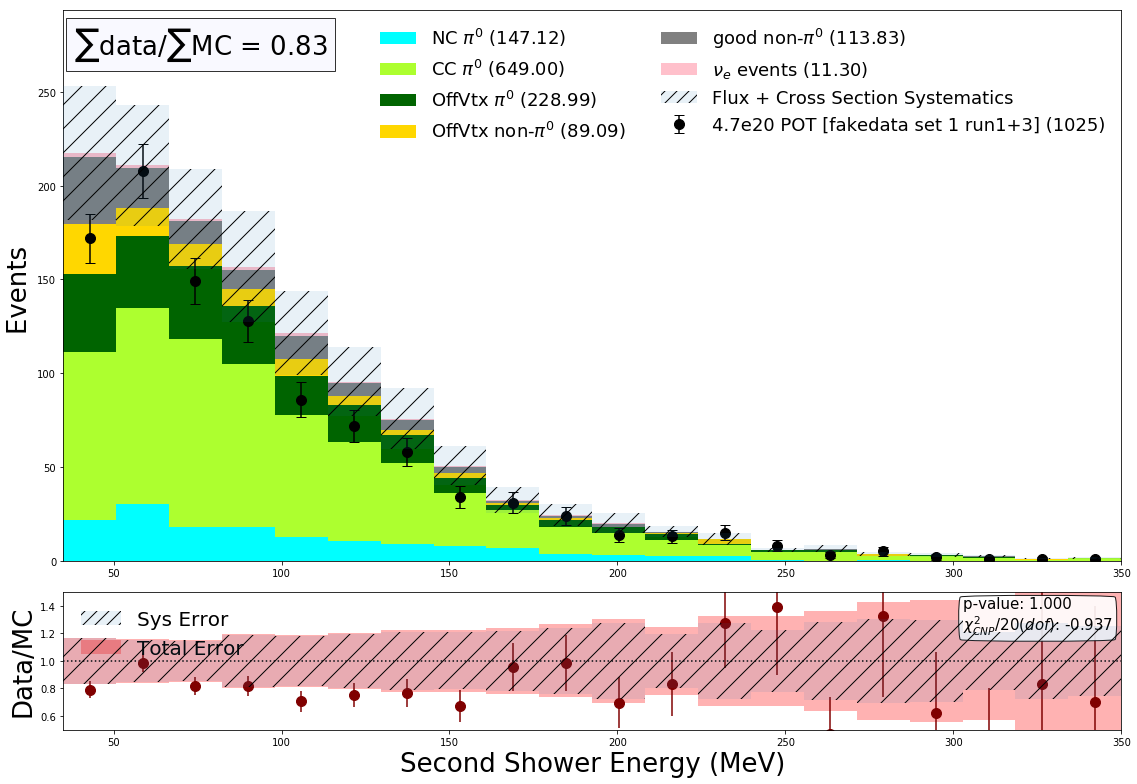

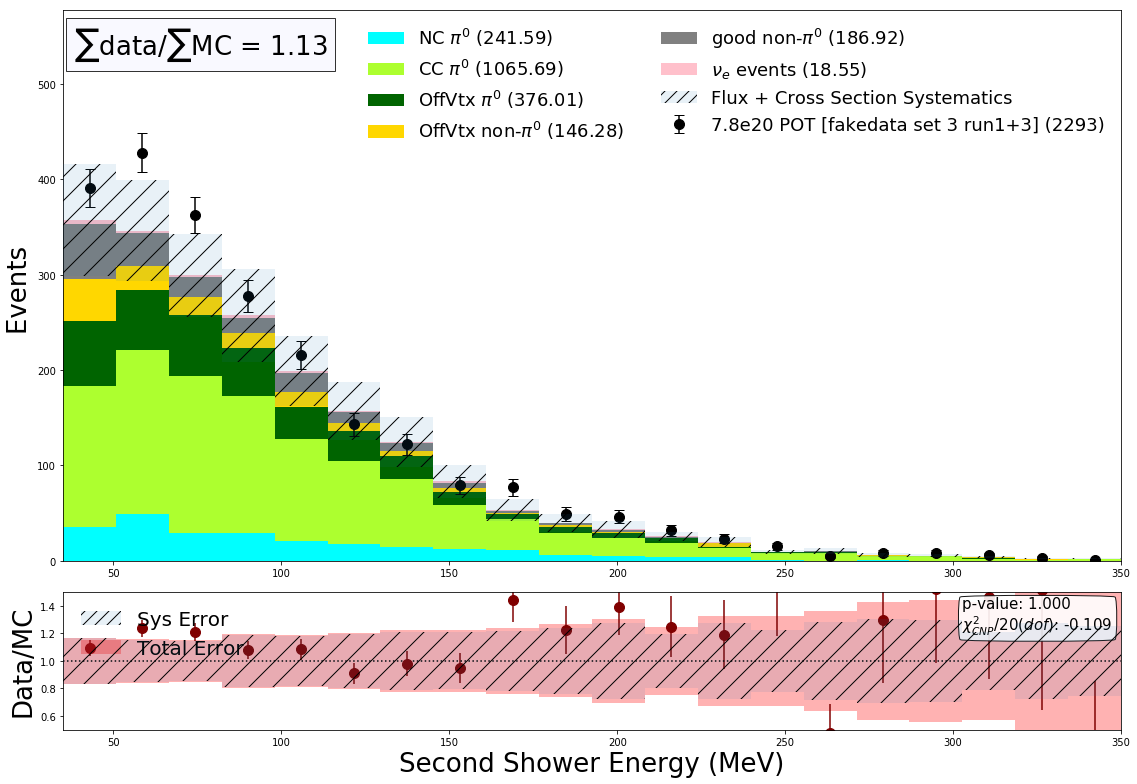

In [21]:
vartest = 'shower2_E_Y'
varname = r'Second Shower Energy (MeV)'
myrange = (35,350)
nbins = 20
# norm = (len(df_numu_total)*NUMU_SCALE_TOTAL+ len(df_nue_total)*NUE_SCALE_TOTAL +len(df_ext_total)*EXT_SCALE_TOTAL)/len(df_data_total)
# norm = 1.0/norm
print("norm: ",norm)
norm = 1.0
set1Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUE_SCALE_TOTAL_1*norm))
set1Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set1Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set1Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set1Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set1Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set1Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set1DataHist = SimpleHisto(df_data_total_1,DATA_SCALE_TOTAL_1,0,'','4.7e20 POT [fakedata set 1 run1+3]')
fig,ax0,_ = distplot_wratio_davio(vartest,nbins,myrange,set1Hists,set1DataHist,varname,s_cov ='../systematics/covar_comb_full__shower2_energy_reco.txt')

set3Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUE_SCALE_TOTAL_3*norm))
set3Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set3Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set3Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set3Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set3Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set3Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set3DataHist = SimpleHisto(df_data_total_3,DATA_SCALE_TOTAL_3,0,'','7.8e20 POT [fakedata set 3 run1+3]')
fig3,ax03,_ = distplot_wratio_davio(vartest,nbins,myrange,set3Hists,set3DataHist,varname,s_cov ='../systematics/covar_comb_full__shower2_energy_reco.txt')


norm:  1.0
[21.88203429 25.05904236 23.5957371  27.08308238 21.60216272 22.91850085
 17.97122111 13.64606596 11.09573359  9.04934987  4.43080737  5.79284828
  3.38844387  2.45828979  3.05467347  2.29608154  1.98726315  1.77176055
  0.75407034  0.43282794]
[22.97279801 26.2394963  24.69857166 27.98482963 22.52408502 23.73035855
 18.73165908 14.38170069 11.82236813  9.80438997  5.28912281  6.31359411
  4.14646703  3.03643005  3.53740016  2.6963935   2.44893235  2.02560614
  1.19723823  0.65478447]
sqdata 127.40180026657808 0
sqdata 164.9564787110865 1
sqdata 148.6986741231208 2
sqdata 135.75295686473277 3
sqdata 110.48257603978874 4
sqdata 100.35121209442522 5
sqdata 75.20462430527861 6
sqdata 56.04327051052629 7
sqdata 46.350498899141314 8
sqdata 35.89127397826729 9
sqdata 25.988258718719166 10
sqdata 17.700275443015318 11
sqdata 15.436022677844205 12
sqdata 8.587199776138885 13
sqdata 7.994003626607621 14
sqdata 6.380658430036644 15
sqdata 5.271263456839299 16
sqdata 3.4582917325114857

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:112: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



errboxes 20
mc: [141.7074332  175.68680661 154.69517132 144.56608591 118.73435418
 110.31257527  81.61083934  60.38300344  48.88218826  41.77851939
  24.70539234  18.69353014  17.03178475   9.68522772   9.5870556
   6.11034482   6.26716582   2.99634305   2.66720639   0.87617005]
data:  [106. 147. 138. 121.  97.  85.  65.  49.  42.  28.  29.  16.  13.   7.
   6.   7.   4.   5.   2.   5.]
Events: 972.0
Min Bin ct (data): 2.0
[35.93163486 41.14847586 38.74563938 44.47207302 35.47206868 37.63357616
 29.5098411  22.40767255 18.21987127 14.85958439  7.27565592  9.51221017
  5.56403149  4.03666176  5.01596014  3.77030592  3.2632073   2.90933887
  1.23822949  0.71072987]
[37.72273541 43.08685323 40.556561   45.952797   36.98592131 38.96669602
 30.75852662 23.61562965 19.4130495  16.09940628  8.68506222 10.36730659
  6.80875175  4.98600332  5.8086268   4.42764257  4.02129627  3.32616882
  1.96593819  1.07519603]
sqdata 232.79474151422028 0
sqdata 304.62609998675225 1
sqdata 266.08033792183573 2

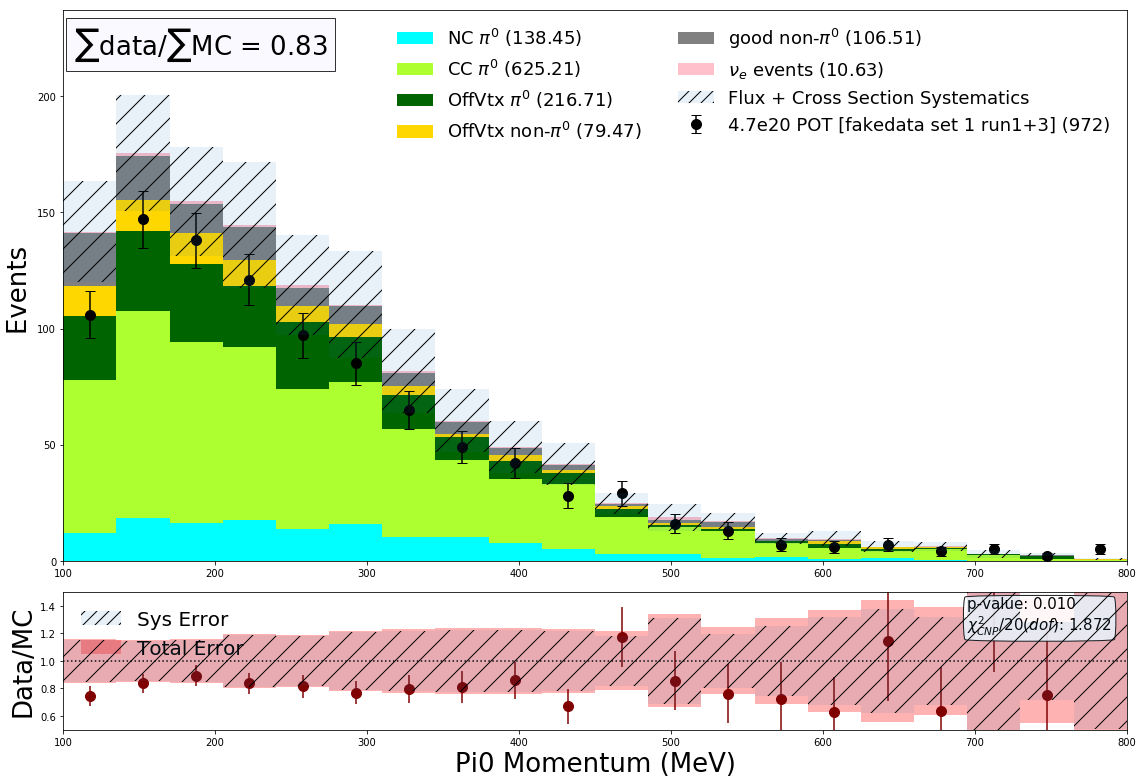

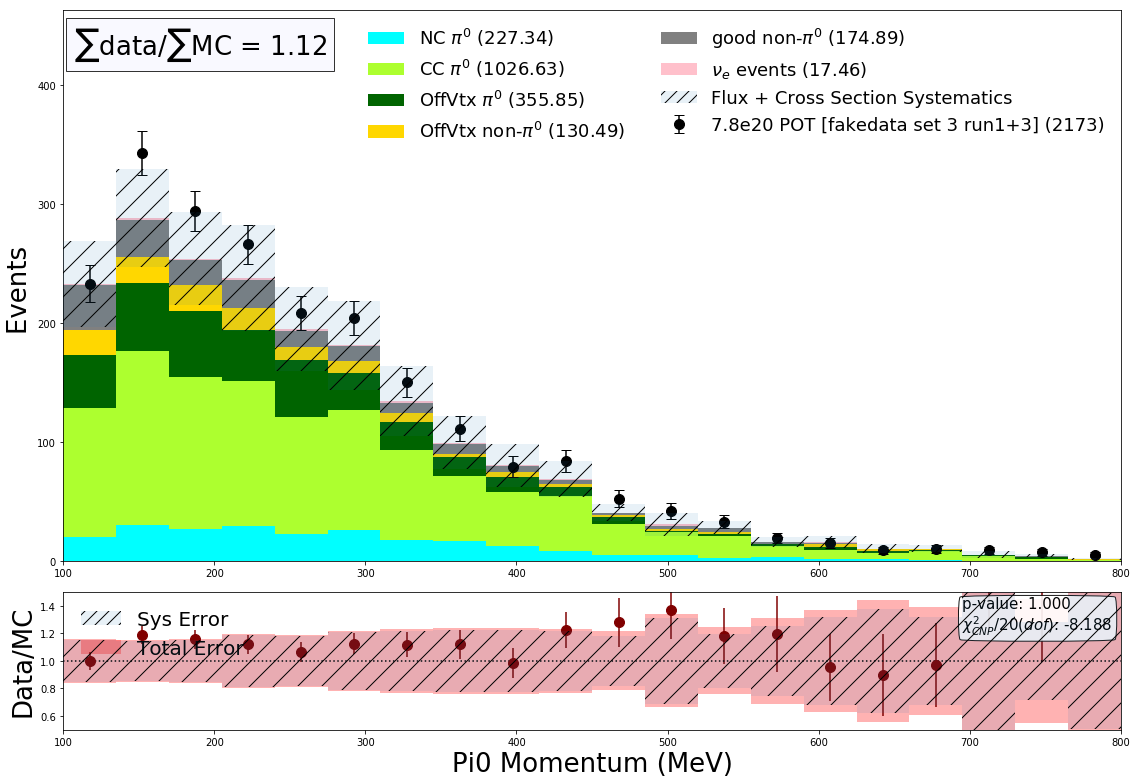

In [22]:
vartest = 'Pi0Momentum_reco'
varname = r'Pi0 Momentum (MeV)'
myrange = (100,800)
nbins = 20
# norm = (len(df_numu_total)*NUMU_SCALE_TOTAL+ len(df_nue_total)*NUE_SCALE_TOTAL +len(df_ext_total)*EXT_SCALE_TOTAL)/len(df_data_total)
# norm = 1.0/norm
print("norm: ",norm)
norm = 1.0
set1Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUE_SCALE_TOTAL_1*norm))
set1Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set1Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set1Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set1Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set1Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set1Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set1DataHist = SimpleHisto(df_data_total_1,DATA_SCALE_TOTAL_1,0,'','4.7e20 POT [fakedata set 1 run1+3]')
fig,ax0,_ = distplot_wratio_davio(vartest,nbins,myrange,set1Hists,set1DataHist,varname,s_cov ='../systematics/covar_comb_full__pi0_momentum_reco.txt')

set3Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUE_SCALE_TOTAL_3*norm))
set3Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set3Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set3Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set3Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set3Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set3Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set3DataHist = SimpleHisto(df_data_total_3,DATA_SCALE_TOTAL_3,0,'','7.8e20 POT [fakedata set 3 run1+3]')
fig3,ax03,_ = distplot_wratio_davio(vartest,nbins,myrange,set3Hists,set3DataHist,varname,s_cov ='../systematics/covar_comb_full__pi0_momentum_reco.txt')


norm:  1.0
[ 0.          0.          9.03929686 25.81461176 37.96706684 39.84112427
 34.77188332 30.73236463 23.4768926  16.86522753 14.15071832  7.47900363
  5.12420903  6.20501144  3.12430281  3.12895821  1.50666298  1.93772906
  2.40284483  0.64073055]
[ 0.          0.         10.0701812  26.7194735  38.87485152 40.66595115
 35.51611258 31.52311621 24.19249603 17.54565884 14.79643661  8.32681105
  5.88227527  6.73099158  3.82416562  3.55127282  2.17955634  2.35841881
  2.64575686  1.00662218]
sqdata 53.61405701275667 2
sqdata 132.06375387469117 3
sqdata 190.97202953611247 4
sqdata 180.03973993620804 5
sqdata 139.67149467851317 6
sqdata 131.57334840144742 7
sqdata 91.72122527598347 8
sqdata 62.109144039925376 9
sqdata 50.80720914749493 10
sqdata 38.962956496611845 11
sqdata 23.41240022383776 12
sqdata 18.152988682111083 13
sqdata 12.724482397421486 14
sqdata 7.517827933598438 15
sqdata 7.716292760175268 16
sqdata 5.386179183722489 17
sqdata 2.934999529403725 18
sqdata 2.4585202832049

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:112: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



errboxes 20
mc: [  0.           0.          56.94413648 137.74503301 202.11915321
 192.79561948 152.14172435 143.35465819  99.75272452  68.79637973
  55.06688904  39.46297129  24.83911161  20.28492684  14.73123143
   8.60641617   7.58185359   5.60253752   3.83034138   1.96031117]
data:  [  0.   0.  48. 122. 172. 159. 120. 113.  79.  52.  44.  38.  21.  15.
  10.   6.   8.   5.   2.   5.]
Events: 1019.0
Min Bin ct (data): 0.0


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:333: RuntimeWarning: invalid value encountered in true_divide


[ 0.          0.         14.84307674 42.38916691 62.3442393  65.4215559
 57.0975531  50.46441704 38.55048947 27.69373219 23.23634251 12.28098009
  8.41426374 10.18900722  5.13029576  5.13794022  2.4740325   3.18186929
  3.94561776  1.05211865]
[ 0.          0.         16.5358517  43.87500506 63.83487711 66.77597194
 58.31962293 51.76287936 39.72555394 28.81104189 24.29665132 13.67313159
  9.65905474 11.05269868  6.27951317  5.83140655  3.57896443  3.87266752
  4.34449412  1.65293501]
sqdata 94.64218463263636 2
sqdata 243.37590078231847 3
sqdata 347.06724132390053 4
sqdata 326.6975692464225 5
sqdata 257.1007840039222 6
sqdata 237.8779757124366 7
sqdata 169.44831683024782 8
sqdata 116.42045277391871 9
sqdata 93.97865770513125 10
sqdata 64.86693436847459 11
sqdata 45.05946453788196 12
sqdata 35.01208468672181 13
sqdata 26.5526067709048 14
sqdata 14.974266094015864 15
sqdata 10.502572629288656 16
sqdata 9.975674959735903 17
sqdata 6.77227643335555 18
sqdata 3.9257886582060544 19
data_scale

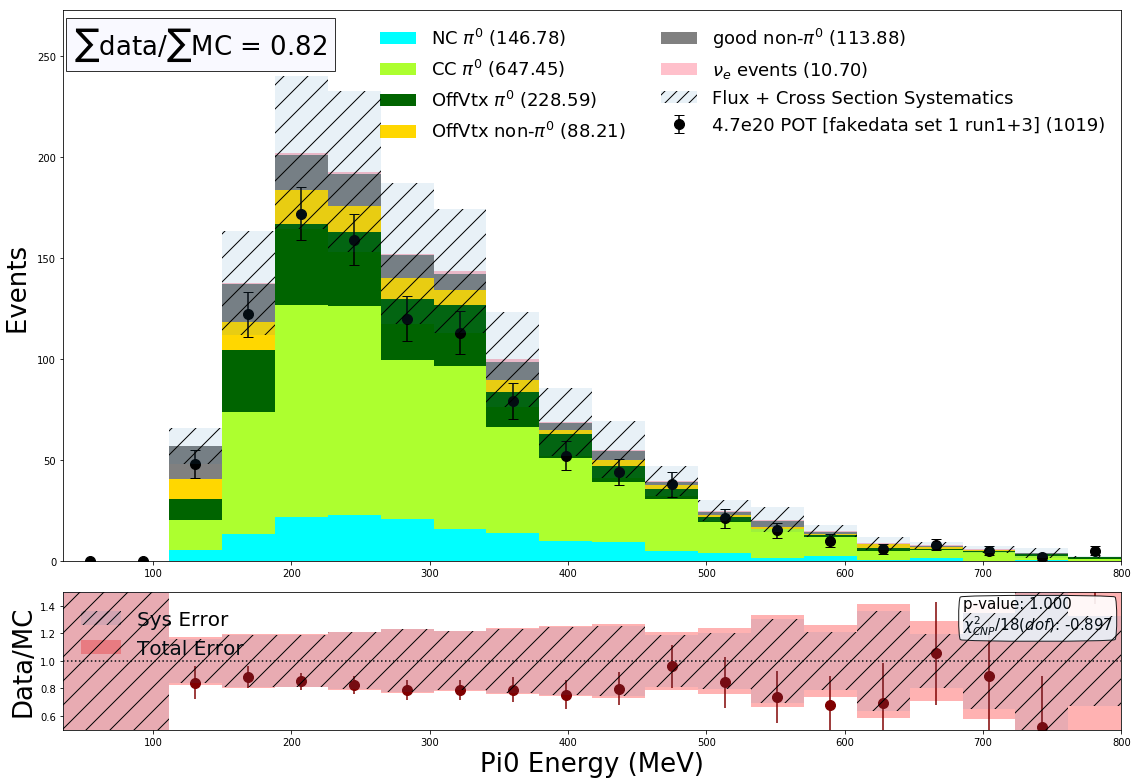

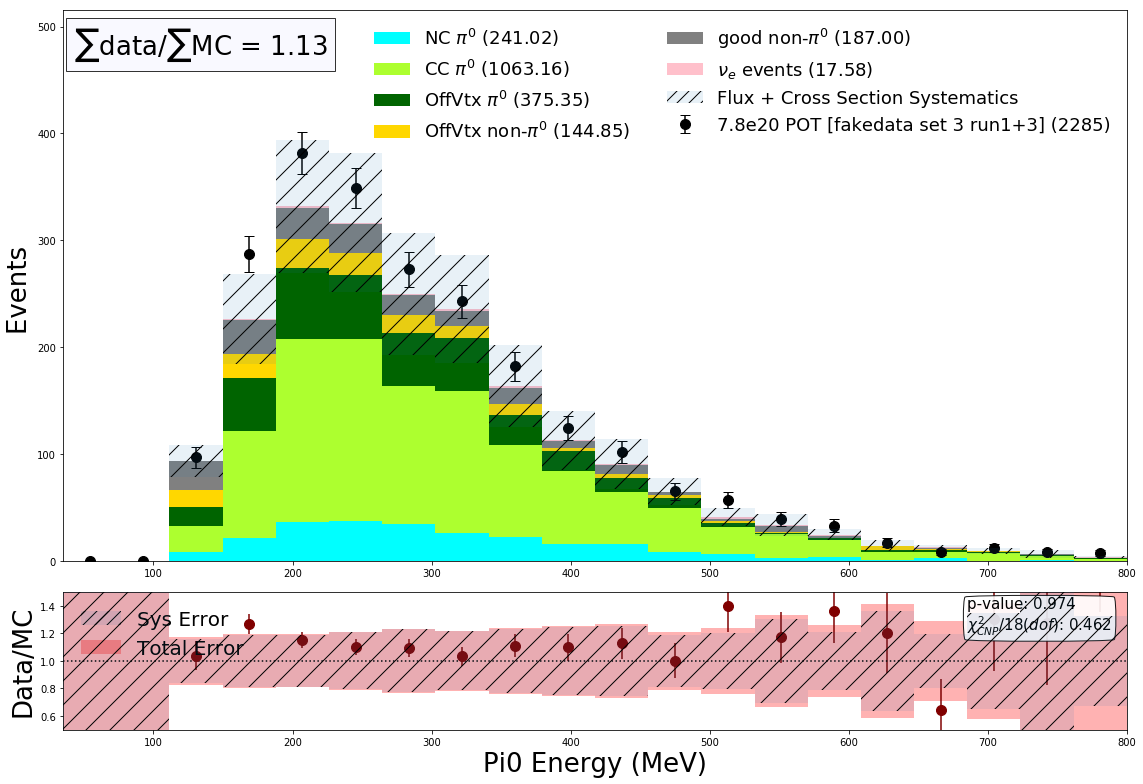

In [23]:
vartest = 'Pi0Energy_reco'
varname = r'Pi0 Energy (MeV)'
myrange = (35,800)
nbins = 20
# norm = (len(df_numu_total)*NUMU_SCALE_TOTAL+ len(df_nue_total)*NUE_SCALE_TOTAL +len(df_ext_total)*EXT_SCALE_TOTAL)/len(df_data_total)
# norm = 1.0/norm
print("norm: ",norm)
norm = 1.0
set1Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUMU_SCALE_TOTAL_1*norm,NUE_SCALE_TOTAL_1*norm))
set1Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set1Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set1Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set1Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set1Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set1Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set1DataHist = SimpleHisto(df_data_total_1,DATA_SCALE_TOTAL_1,0,'','4.7e20 POT [fakedata set 1 run1+3]')
fig,ax0,_ = distplot_wratio_davio(vartest,nbins,myrange,set1Hists,set1DataHist,varname,s_cov ='../systematics/covar_comb_full__pi0_energy_reco.txt')

set3Hists = StackedHisto((df_bnb_ncpi0_total,df_bnb_ccpi0_total,df_bnb_pi0_offvtx_total,df_bnb_other_offvtx_total,df_bnb_other_good_total,df_nue_total),(NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUMU_SCALE_TOTAL_3*norm,NUE_SCALE_TOTAL_3*norm))
set3Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
set3Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
set3Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
set3Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
set3Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
set3Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
set3DataHist = SimpleHisto(df_data_total_3,DATA_SCALE_TOTAL_3,0,'','7.8e20 POT [fakedata set 3 run1+3]')
fig3,ax03,_ = distplot_wratio_davio(vartest,nbins,myrange,set3Hists,set3DataHist,varname,s_cov ='../systematics/covar_comb_full__pi0_energy_reco.txt')
